In [0]:
use_gdrive = True
use_nb = True

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/gdrive')#, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import platform
print(platform.python_version())

3.6.8


In [0]:
!pip install hiddenlayer
#!pip install tensorboardX
#!pip install colormap
#!pip install easydev
#!pip install tqdm

In [0]:
#import pdb
import sys
import os
#import argparse
#import logging
#import json
import time

import torch
print(f"Torch Version {torch.__version__}")
#from torch.utils.data import DataLoader
#from torch.autograd import Variable
import torch.nn
#from torch.nn import BCEWithLogitsLoss, DataParallel
#from torch.optim import SGD

#from tensorboardX import SummaryWriter

#sys.path.append(os.path.dirname(os.path.abspath(__file__)) + '/../../')

# put this into every cell that makes random choices
torch.manual_seed(42)
if torch.cuda.is_available():
  print("GPU is available.")
  torch.cuda.manual_seed_all(42)

#from wsi.data.image_producer import GridImageDataset  # noqa
#from wsi.model import MODELS  # noqa

Torch Version 1.1.0
GPU is available.


In [0]:
import ntpath
ntpath.basename("a/b/c")
import os
#import h5py
import numpy as np
#import random
# import keras.backend.tensorflow_backend as K
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.convolutional import Convolution2D, MaxPooling2D
#from keras.optimizers import adam
#from keras.utils import np_utils
#from keras.callbacks import EarlyStopping
#import cv2
import matplotlib.pyplot as plt
#from PIL import Image
#import glob
#import skimage.io as io
#import skimage.transform as trans
#import math
import tqdm

#def path_leaf(path):
#  head, tail = ntpath.split(path)
#  return tail or ntpath.basename(head)

In [0]:
import torchvision as tv

# resize h, w to 292 x 438 = 2336 x 3504 / 8 each
toTensor = tv.transforms.ToTensor()
ToPILImage = tv.transforms.ToPILImage()

def get_G_band(img):
  """
  img: pytorch tensor of shape (3, h, w)
  """
  # get green channel/band by setting R and B bands to 0
  img_g = img.clone()
  img_g[0,:,:] = 0
  img_g[2,:,:] = 0
  return img_g

def get_G_band_(img):
  """
  img: pytorch tensor of shape (h, w, 3)
  """
  img_copy = img.clone()
  img_copy[:,:,0] = 0
  img_copy[:,:,2] = 0
  return img_copy

def get_R_band_(img):
  """
  img: pytorch tensor of shape (h, w, 3)
  """
  # get red channel/band by setting other bands to 0
  img_copy = img.clone()
  img_copy[:,:,1] = 0
  img_copy[:,:,2] = 0
  return img_copy

def get_B_band_(img):
  """
  img: pytorch tensor of shape (h, w, 3)
  """
  # get blue channel/band by setting other bands to 0
  img_copy = img.clone()
  img_copy[:,:,0] = 0
  img_copy[:,:,1] = 0
  return img_copy

In [0]:
def extract_gxy(img_ten, debug=False):
  """builds the old shape (#img, h*w, 3) instead of (#img, 3*h*w)
  
  img_g_ten: tensor of shape (3, h, w) [the 3 being the RGB channels], whose R and B bands are either empty or will be ignored by this method
  # output 
  feats: tensor of shape torch.Size([127896, 3]), gxy features * flattened pixels
  """
  # img_ten.shape = (3, h, w)
  _, h, w = img_ten.shape
  if debug:
    print(h, w)
  img_g_ten = get_G_band(img_ten)
  # let's stack up our tensor feature sandwich "feats"!
  g = img_g_ten[1]
  if debug:
    print(g.shape)
  g.unsqueeze_(2)
  if debug:
    print(g.shape)
  x = torch.arange(0, h, dtype=torch.float).repeat_interleave(w).resize(h, w)
  if debug:
    print(x.shape)
  # extend by empty dimension at position 0 so they can be concatenated by that dimension later
  x.unsqueeze_(2)
  if debug:
    print(x.shape)
  y = torch.arange(0, w, dtype=torch.float).repeat(h).resize(h, w)
  if debug:
    print(y.shape)
  y.unsqueeze_(2)
  if debug:
    print(y.shape)
  # dim=0 concatenate among 0-dimension, which all vectors have as they were unsqueezed
  feats = torch.cat((g, x, y), dim=2)
  if debug:
    print(f"feats shape: {feats.shape}")
    print(f"Top left pixel is value {feats[0,0,0]}")
    plt.imshow(feats[:,:,0], cmap='Greys')
    if use_nb:
      plt.show()
    plt.imshow(feats[:,:,1], cmap='Greys')
    if use_nb:
      plt.show()
    plt.imshow(feats[:,:,2], cmap='Greys')
    if use_nb:
      plt.show()
  # shape = features x pixels
  if debug:
    print(feats.shape)
  #feats = feats.view(h, w, 3)  # put tensor back into shape
  return feats


In [0]:
def min_val(tens, *dims):
  """dims have to be in ascending order for this to work
  tens: torch.tensor
  *dims: integers indeces along which to take min
  returns torch.tensor with minima, collapsed along the given dimensions"""
  if len(dims) > tens.dim():
    raise Exception("len(dims) > tens.dim()")
  if len(dims) == 1:
    return tens.min(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0])
  elif len(dims) == 2:
    r = tens.min(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).min(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1])
    return r
  elif len(dims) == 3:
    return tens.min(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).min(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1]).min(dim=list(dims)[2]).values.unsqueeze(dim=list(dims)[2])
  else:
    raise Exception

## test
#a = torch.tensor([[0, -1, 5], [6, 7, -2]])
#print(a)
#print(min_val(a, 0))
#print(min_val(a, 1))
#print(min_val(a, 0, 1))

In [0]:
def max_val(tens, *dims):
  """dims have to be in ascending order for this to work
  tens: torch.tensor
  *dims: integers indeces along which to take max
  returns torch.tensor with maxima, collapsed along the given dimensions"""
  if len(dims) > tens.dim():
    raise Exception
  if len(dims) == 1:
    return tens.max(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0])
  elif len(dims) == 2:
    r = tens.max(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).max(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1])
    return r
  elif len(dims) == 3:
    return tens.max(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).max(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1]).max(dim=list(dims)[2]).values.unsqueeze(dim=list(dims)[2])
  else:
    raise Exception
# test
a = torch.tensor([[0, -1, 5], [6, 7, -2]])
print(a)
print(max_val(a, 0))
print(max_val(a, 1))
print(max_val(a, 0, 1))

tensor([[ 0, -1,  5],
        [ 6,  7, -2]])
tensor([[6, 7, 5]])
tensor([[5],
        [7]])
tensor([[7]])


In [0]:
def normalize(X):
  """normalize into range [-1, 1]
  also called 'scaling'
  input: torch.tensor of shape (n, h, w, f), image feature dataset (training, validation or test) where first feature contains intensities to be normalized
  output: torch.tensor of shape (n, h, w, f), normalized image feature dataset"""
  
  X_min = min_val(X, 1, 2)
  X_max = max_val(X, 1, 2)
  #pdb.set_trace()
  return 2*(X - X_min) / (X_max - X_min) - 1

# test normalization function
a = torch.rand((1,2,2,3))
print(a)
print(a.shape)
print(normalize(a))
print(normalize(a).shape)

tensor([[[[0.8823, 0.9150, 0.3829],
          [0.9593, 0.3904, 0.6009]],

         [[0.2566, 0.7936, 0.9408],
          [0.1332, 0.9346, 0.5936]]]])
torch.Size([1, 2, 2, 3])
tensor([[[[ 0.8135,  0.9280, -1.0000],
          [ 1.0000, -1.0000, -0.2184]],

         [[-0.7013,  0.4819,  1.0000],
          [-1.0000,  1.0000, -0.2446]]]])
torch.Size([1, 2, 2, 3])


In [0]:
# Ruta preprocessed features
# X_train_val

if use_gdrive:
  input_path = "/content/gdrive/My Drive/Master_Thesis/features/"
else:
  input_path = "./features/"

h, w = 292, 438

# features_masked means outside the FOV the pixels have been set to 0
X_train_val = np.load(input_path+"features_masked.npy")

# it runs out here:
# RuntimeError: CUDA out of memory. Tried to allocate 528.00 MiB (GPU 0; 11.17 GiB total capacity; 7.83 GiB already allocated; 832.00 KiB free; 955.70 MiB cached)
X_train_val = torch.from_numpy(X_train_val).float().cuda()
#val_feats = val_feats.view(9, w*h, 30) #val_feats.view(9, w, h, 30)
X_train_val = X_train_val.view(36, 30, h, w)

#X_train_val = X_train_val.view(9, h, w, 30)
X_train_val = X_train_val.transpose(1, 3).transpose(1, 2)
print(X_train_val.shape)
print("dim", X_train_val.dim())

for i in range(4): #range(30):
  # x position
  # y position
  # g channel intensity
  # 27 other features
  print(f"feature {i+1}")
  plt.imshow(X_train_val[0,:,:,i].cpu()) # if no plt.show is called, only the last imshow is shown
  if use_nb:
    #plt.show()
    plt.clf()
  else:
    plt.clf()

# validation -> split

torch.Size([36, 292, 438, 30])
dim 4
feature 1
feature 2
feature 3
feature 4


<Figure size 432x288 with 0 Axes>

In [0]:
# normalized between [0, 1], but we need them in range [-1, 1]
# actually it shouldn't matter?!?
#for i in range(30):
#  print(torch.min(X_train_val[0,:,:,i]).item(), torch.max(X_train_val[0,:,:,i]).item())

In [0]:
# Ruta preprocessed features
# X_test

# masked means outside the FOV the pixels have been set to 0
npzfile = np.load(input_path+"test_features_masked.npz")
print(npzfile.files)
print(npzfile['features_masked'].shape)
X_test = npzfile['features_masked'] # numpy array
X_test = torch.from_numpy(X_test).float().cuda()
#X_test = X_test.view(9, w*h, 30) #X_test.view(9, w, h, 30)
X_test = X_test.view(9, 30, h, w)
print("X_test dtype", X_test.shape)
print("dim", X_test.dim())

#X_test = X_test.view(9, h, w, 30)
print(X_test.shape)
X_test = X_test.transpose(1, 3).transpose(1, 2)
print(X_test.shape)

['features_masked']
(9, 30, 127896)
X_test dtype torch.Size([9, 30, 292, 438])
dim 4
torch.Size([9, 30, 292, 438])
torch.Size([9, 292, 438, 30])


In [0]:
for i in range(4):#range(30):
  plt.imshow(X_test[0,:,:,i].cpu())
  if use_nb:
    #plt.show()
    plt.clf()
  else:
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [0]:
#for i in range(30):
#  print(torch.min(X_train_val[0,:,:,i]).item(), torch.max(X_train_val[0,:,:,i]).item())

In [0]:
#for i in range(30):
#  print(torch.min(X_test[0,:,:,i]).item(), torch.max(X_test[0,:,:,i]).item())

In [0]:
#for i in range(4):#range(30):
#  print(X_test[0,:,:,i].shape)

In [0]:
#npzfile = np.load(input_path+"train_same.npz")
#for file in npzfile.files:
#  print(file)
#  print(npzfile[file].shape)
#  
## segmentations_binary did not average the labels when resizing and but used a majority vote instead, retaining binary labels
## averaging interpolation pretains more information, thus we will use these

In [0]:
#npzfile = np.load(input_path+"test_same.npz")
#for file in npzfile.files:
#  print(file)
#  print(npzfile[file].shape)

In [0]:
npzfile = np.load(input_path+"train_same.npz")  # 'train_same' means train
y_train_val = npzfile['segmentations']  # segmentations means these are the ground truth labelings, i.e. y
mask_train_val = npzfile['masks']
print(type(y_train_val))
print(type(mask_train_val))

#y_train_bin = npzfile['segmentations_binary']
#plt.imshow(y_train[0])
#plt.show()
#plt.imshow(y_train_bin[0])
#plt.show()

npzfile = np.load(input_path+"test_same.npz")
y_test = npzfile['segmentations']
mask_test = npzfile['masks']


y_train_val = toTensor(y_train_val)
y_test = toTensor(y_test)
mask_train_val = toTensor(mask_train_val)
mask_test = toTensor(mask_test)
print(type(y_train_val))
print(type(y_test))
print('train labels shape: ', y_train_val.shape)
print('test labels shape: ', y_test.shape)
y_train_val = y_train_val.transpose(0, 1).transpose(1, 2)
y_test = y_test.transpose(0, 1).transpose(1, 2)
mask_train_val = mask_train_val.transpose(0, 1).transpose(1, 2)
mask_test = mask_test.transpose(0, 1).transpose(1, 2)
y_train_val = y_train_val.to(dtype=torch.float32).cuda()
y_test = y_test.to(dtype=torch.float32).cuda()
mask_train_val = mask_train_val.to(dtype=torch.float32).cuda()
mask_test = mask_test.to(dtype=torch.float32).cuda()
print('train labels dtype: ', y_train_val.dtype)
print('test labels dtype: ', y_test.dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train labels shape:  torch.Size([438, 36, 292])
test labels shape:  torch.Size([438, 9, 292])
train labels dtype:  torch.float32
test labels dtype:  torch.float32


In [0]:
# Ruta split
torch.manual_seed(2809)
np.random.seed(2809)

n = len(X_train_val) #[:3])
val_n = int(n/3)
print(f"n: {n}\nval_n: {val_n}")  # n = 36 -> train_n = 24 and val_n = 12 
batchIndices = np.arange(n)

shuffle = True

if(shuffle):
  batchIndices = np.random.permutation(batchIndices) # Shuffle frames 
print(f"batchIndices: {batchIndices}")

trainIdx = batchIndices[ val_n: ] # skip the val_N first entries for training set
valIdx = batchIndices[ :val_n ] # take the val_n fisrt entries for validation set
print(f"trainIdx: {trainIdx}")
print(f"valIdx: {valIdx}")

# can't cast list to tensor: ValueError: only one element tensors can be converted to Python scalars
# instead look at dmadeka1 in https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868
#X_val = torch.FloatTensor([X_train_val[i] for i in valIdx])
#
#y_train = torch.FloatTensor([y_train_val[i] for i in trainIdx])
#y_val = torch.FloatTensor([y_train_val[i] for i in valIdx])

  
X_train = torch.stack([X_train_val[i] for i in trainIdx])  # or use toTensor(...) ?
X_val = torch.stack([X_train_val[i] for i in valIdx])

y_train = torch.stack([y_train_val[i] for i in trainIdx])
y_val = torch.stack([y_train_val[i] for i in valIdx])

mask_train = torch.stack([mask_train_val[i] for i in trainIdx])
mask_val = torch.stack([mask_train_val[i] for i in valIdx])

n: 36
val_n: 12
batchIndices: [11 19 35 21 31  5 15 22 34  7 23 10 13  3 17 33  0 24 14 27 26 29 20  4
 28  2  1 32 12  8  9  6 30 16 18 25]
trainIdx: [13  3 17 33  0 24 14 27 26 29 20  4 28  2  1 32 12  8  9  6 30 16 18 25]
valIdx: [11 19 35 21 31  5 15 22 34  7 23 10]


In [0]:
# normalized between [0, 1], but we need them in range [-1, 1]
# actually it shouldn't matter?!?
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [0]:
_, h, w, F = X_train.shape
N = h*w

print(f"h, w, F: {h}, {w}, {F}")
print(f"N: {N}")

print('train images shape: ', X_train.shape)
print('train labels shape: ', y_train.shape)
print('train masks shape: ', mask_train.shape)
print('valid images shape: ', X_val.shape)
print('valid labels shape: ', y_val.shape)
print('valid masks shape: ', mask_val.shape)
print('test images shape: ', X_test.shape)
print('test labels shape: ', y_test.shape)
print('test masks shape: ', mask_test.shape)

print('train images dtype: ', X_train.dtype)
print('train labels dtype: ', y_train.dtype)
print('train masks dtype: ', mask_train.dtype)
print('valid images dtype: ', X_val.dtype)
print('valid labels dtype: ', y_val.dtype)
print('valid masks dtype: ', mask_val.dtype)
print('test images dtype: ', X_test.dtype)
print('test labels dtype: ', y_test.dtype)
print('test masks dtype: ', mask_test.dtype)

print('train images is_cuda: ', X_train.is_cuda)
print('train labels is_cuda: ', y_train.is_cuda)
print('train masks is_cuda: ', mask_train.is_cuda)
print('valid images is_cuda: ', X_val.is_cuda)
print('valid labels is_cuda: ', y_val.is_cuda)
print('valid masks is_cuda: ', mask_val.is_cuda)
print('test images is_cuda: ', X_test.is_cuda)
print('test labels is_cuda: ', y_test.is_cuda)
print('test masks is_cuda: ', mask_test.is_cuda)

h, w, F: 292, 438, 30
N: 127896
train images shape:  torch.Size([24, 292, 438, 30])
train labels shape:  torch.Size([24, 292, 438])
train masks shape:  torch.Size([24, 292, 438])
valid images shape:  torch.Size([12, 292, 438, 30])
valid labels shape:  torch.Size([12, 292, 438])
valid masks shape:  torch.Size([12, 292, 438])
test images shape:  torch.Size([9, 292, 438, 30])
test labels shape:  torch.Size([9, 292, 438])
test masks shape:  torch.Size([9, 292, 438])
train images dtype:  torch.float32
train labels dtype:  torch.float32
train masks dtype:  torch.float32
valid images dtype:  torch.float32
valid labels dtype:  torch.float32
valid masks dtype:  torch.float32
test images dtype:  torch.float32
test labels dtype:  torch.float32
test masks dtype:  torch.float32
train images is_cuda:  True
train labels is_cuda:  True
train masks is_cuda:  True
valid images is_cuda:  True
valid labels is_cuda:  True
valid masks is_cuda:  True
test images is_cuda:  True
test labels is_cuda:  True
test

In [0]:
plt.imshow(y_test[0,:,:].detach().cpu())

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
if use_gdrive:
  plt.savefig(f"/content/gdrive/My Drive/Master_Thesis/ground_truth_hr_noaxis.png", bbox_inches = 'tight', pad_inches = 0)
else:
  plt.savefig(f"./ground_truth_hr_noaxis.png", bbox_inches = 'tight', pad_inches = 0)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [0]:
n_images = 3
fig=plt.figure(figsize=(10, 10))
for i, (image, label) in list(enumerate(zip(X_val, y_val)))[:n_images]:
  plt.subplot(n_images, 2, 2*i+1)
  plt.imshow(image.cpu()[:,:,2]) # intensities of val image
  plt.xticks([])
  plt.yticks([])
  
  plt.subplot(n_images, 2, 2*i+2)
  plt.imshow(label.cpu()) # label has dim {h, w}
  plt.xticks([])
  plt.yticks([])

if use_gdrive:
  output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/"
else:
  output_path = "./"
plt.savefig(output_path+"intensities_and_ground_truths_john_doe.png")
plt.clf()

<Figure size 720x720 with 0 Axes>

In [0]:
import torch.nn.functional as Fun

a = torch.FloatTensor([[3],[2]])
b = torch.FloatTensor([[1],[1]])

print(a.shape)
print(a)

dist = Fun.pairwise_distance(a, b)
print(dist)

torch.Size([2, 1])
tensor([[3.],
        [2.]])
tensor([2.0000, 1.0000])


In [0]:
#?torch.nn.PairwiseDistance

In [0]:
for i, (r, label) in list(enumerate(zip(range(3), y_val)))[:3]:
  plt.imshow(label.cpu()) # intensities of val image
  if use_nb:
    #plt.show()
    plt.clf()
  else:
    plt.clt()

<Figure size 432x288 with 0 Axes>

In [0]:
def threshold(tensor, T):
  index_tensor = tensor > T
  binary_tensor = torch.zeros(index_tensor.shape)
  binary_tensor[index_tensor] = 1
  return binary_tensor

#a = torch.randn((5,5))
#thresholding(a, 0.5)

In [0]:
# source: user Danijel at https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python
class Timer:
  def __init__(self):
    self.start = time.time()

  def restart(self):
    self.start = time.time()

  def get_time_hhmmss(self):
    end = time.time()
    m, s = divmod(end - self.start, 60)
    h, m = divmod(m, 60)
    time_str = "%02dh%02dm%02ds" % (h, m, s)
    return time_str

In [0]:
# source: https://github.com/pytorch/pytorch/issues/1249
def dice_loss(y_pred, y_true):
  """
  dice score(A, B) = 2 * |intersection(A, B)| / |A| + |B|
  dice loss = 1-dice_score
  """
  #raise Exception(f"{y_pred.unique()}, {y_true.unique()}")
  smooth = 1.
  pflat = y_pred.view(-1)
  tflat = y_true.view(-1)
  #print(pflat.dtype) # float32
  #print(tflat.dtype) # float32
  # since both "y" tensors are 0,1-binary, their element-wise product will tell us where both are 1 -> intersection
  intersection = (pflat * tflat).sum()
  
  # smooth prevents dividing by 0 and ??
  # the set size of A is the number of elements in A which corresonds to the number of 1's in A -> sum
  res = 1 - ((2. * intersection + smooth) /
            (pflat.sum() + tflat.sum() + smooth))
  #print(f"res: {res}")
  #print(f"res type: {type(res)}")
  if torch.isnan(res).any():
    print("dice_loss is nan")
    print(f"num: {(2. * intersection + smooth)}")
    print(f"denom: {(pflat.sum() + tflat.sum() + smooth)}")
    #print(f"denom: {(2*pflat.sum() + tflat.sum() + smooth)}")  # punish predicting vessel more, by multiplying pflat!
    raise Exception
  return res

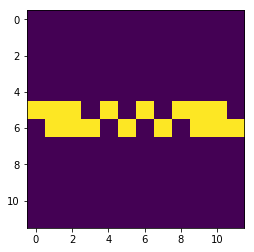

In [0]:
import numpy as np
import torch

def mk_sparse_adj(h, w):
  """
  Constructs a sparse, binary adjacency matrix for an image of dimnesions h, w.
  Each pixel is connected to 8 surrounding pixels and itself, 
  except for the pixels at the border, which have no outgoing connections 
  (only incoming ones).
  returns: (N, N) sparse adj
  """
  N = h*w
  image = np.arange(N)
  x = np.array([])
  for i in range(1, h-1):
    #print( np.arange(i*w+1, ((i+1)*w)-1) )
    # 
    x = np.concatenate((x, np.arange(i*w+1, ((i+1)*w)-1 )))
  
  # y is 9 times as long as x
  # len(x) = number of found pixels with neighbours
  # +4 because 3 more but range is exclusive 
  win_slice = np.array([-1, 0, 1])
  #win = np.concatenate((win_slice-w, win_slice, win_slice+w)) # len = 9
  win = np.concatenate((win_slice-w, [-1,1], win_slice+w)) # len = 8
  #print(win) #win[5] = 0
  #y = np.repeat(x, 9) + np.tile(np.concatenate(  ( np.arange(-w-1, -w-1+4), np.arange(-1, -1+4), np.arange(w-1, w-1+4))  ), len(x))
  y = np.repeat(x, 8) + np.tile(win, len(x))
  # get x to same length as y
  x = np.repeat(x, 8)

  #print("x", x)
  #print("y", y)
  
  i = torch.tensor([x, y]).long()  # else it will autocast to double, whereas v is autocast to long and it gives a type error in sparse.FloatTensor
  v = torch.ones(x.shape)
  
  adj = torch.sparse.IntTensor(i, v, torch.Size([N, N])).cuda().coalesce()
  return adj

my_adj_mat = mk_sparse_adj(3, 4)
#print(my_adj_mat)
#print(my_adj_mat._indices())
#print(my_adj_mat._values())
#
#a = 2*my_adj_mat * my_adj_mat
#print(a._indices())
#print(a._values())

plt.imshow(my_adj_mat.to_dense().cpu())
if use_nb:
  plt.show()
  #plt.clf()
else:
  plt.clf()
#def mk_sparse_adj(h, w):
#  """
#  Constructs a binary adjacency matrix for an image of dimnesions h, w.
#  Each pixel is connected to 8 surrounding pixels and itself, 
#  except for the pixels at the border, which have no outgoing connections 
#  (only incoming ones).
#  """
#  N = h*w
#  image = np.arange(N)
#  x = np.array([])
#  for i in range(1, h-1):
#    #print( np.arange(i*w+1, ((i+1)*w)-1) )
#    x = np.concatenate((x, np.arange(i*w+1, ((i+1)*w)-1 )))
#  
#  # y is 9 times as long as x
#  # len(x) = number of found pixels with neighbours
#  # +4 because 3 more but range is exclusive 
#  win_slice = np.array([-1, 0, 1])
#  win = np.concatenate((win_slice-w, win_slice, win_slice+w)) # len = 9
#  #y = np.repeat(x, 9) + np.tile(np.concatenate(  ( np.arange(-w-1, -w-1+4), np.arange(-1, -1+4), np.arange(w-1, w-1+4))  ), len(x))
#  y = np.repeat(x, 9) + np.tile(win, len(x))
#  # get x to same length as y
#  x = np.repeat(x, 9)
#
#  #print("x", x)
#  #print("y", y)
#  
#  i = torch.tensor([x, y]).long()  # else it will autocast to double, whereas v is autocast to long and it gives a type error in sparse.FloatTensor
#  v = torch.ones(x.shape)
#  
#  adj = torch.sparse.IntTensor(i, v, torch.Size([N, N])).cuda()
#  
#  return adj

In [0]:
#?torch.sparse.mm

In [0]:
def sparse_vectorized_cos_sim(adj, feats, eps=1e-6):
  """
  Method used for preprocessing of cosine similarity matrix in sparse logic. (see ~2 cells below)
  Computes similarities in feature space.
  For each edge, the feature vectors of outgoing and ingoing nodes are computed.
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  feats: (N, F) dense feature tensor
  returns: (E) dense tensor of cosine similarities
  """
  N = adj.shape[0]
  nE = adj._nnz()  # number of non-zero elements = number of edges
  eIdx = torch.cuda.LongTensor(np.arange(nE)) # 0 1 2 3 4 5 6 7 8
  vals = torch.cuda.FloatTensor(np.ones(nE))
  
  # Source node transformer
  nIdx = adj._indices()[0, :]
  indices = torch.stack((eIdx, nIdx))
  n2e_in = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N])).coalesce()
  
  # Sink node transformer
  nIdx = adj._indices()[1, :]
  indices = torch.stack((eIdx, nIdx)) # returns tensor([eIdx, nIdx])
  n2e_out = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N])).coalesce()
  
  # debugging with the pen and paper example
  #print(n2e_in.to_dense())
  #print(n2e_out.to_dense())
  
  # Obtain features of source nodes
  #print(f"n2e_in is cuda? {n2e_in.is_cuda}")
  #print(f"feats is cuda? {feats.is_cuda}")
  # should really be calles f_in and f_out
  x_in = torch.mm(n2e_in, feats)#.coalesce()  # (nE, F) = sparse(nE, N) mm dense(N, F)
  # Obtain features of sink nodes
  x_out = torch.mm(n2e_out, feats)#.coalesce()  # (nE, F) = sparse(nE, N) mm dense(N, F)

  # Cosine similarity
  # (nE, F) -> sum over F: (nE)
  # should be num = torch.mm(x_in * x_out.T) + eps
  # https://en.wikipedia.org/wiki/Cosine_similarity
  # cosine sim uses dot product, which is SUM_i (A_i*B_i)
  # E = ((E, F) * (E, F)).sum(1)
  num = (x_in * x_out).sum(1) + eps # A * B, where A = incoming features, B = outgoing features
  denom = torch.norm(x_in, dim=1) * torch.norm(x_out, dim=1) + eps  # norm(A) * norm(B)
  cosSimValues = num/denom  # values tensor for sparse tensor
  if torch.isnan(cosSimValues).any():
    raise Exception(f"num: {num}\ndenom: {denom}")
  #cosSim = torch.cuda.sparse.FloatTensor(adj._indices(), cosSimValues, torch.Size([N, N]))
  return cosSimValues # (E)    #cosSim.coalesce()

def sparse_vectorized_euc_sim(adj, feats, eps=1e-6):
  """
  Method used for preprocessing of euclidean similarity matrix. (see ~2 cells below)
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  feats: (N, F) dense feature tensor
  returns: (E, F) dense tesnor of euclidean similarities
  """
  N = adj.shape[0]
  nE = adj._nnz()  # number of non-zero elements = number of edges
  eIdx = torch.cuda.LongTensor(np.arange(nE)) # 0 1 2 3 4 5 6 7 8
  vals = torch.cuda.FloatTensor(np.ones(nE))
  
  # Source node transformer
  nIdx = adj._indices()[0, :]
  #print(f"eIdx is cuda? {eIdx.is_cuda}")
  #print(f"nIdx is cuda? {nIdx.is_cuda}")
  indices = torch.stack((eIdx, nIdx))
  n2e_in = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N])).coalesce()
  
  # Sink node transformer
  nIdx = adj._indices()[1, :]
  indices = torch.stack((eIdx, nIdx)) # returns tensor([eIdx, nIdx])
  n2e_out = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N])).coalesce()
  
  # Obtain features of source nodes
  #print(f"n2e_in is cuda? {n2e_in.is_cuda}")
  #print(f"feats is cuda? {feats.is_cuda}")
  x_in = torch.mm(n2e_in, feats)  # (E, F) = (E, N) mm (N, F)  # dense = sparse * dense
  # Obtain features of sink nodes
  x_out = torch.mm(n2e_out, feats)  # (E, F) = (E, N) mm (N, F)  # dense = sparse * dense
  
  
  # euclidian distance
  #euc_dist = torch.sqrt(((x_in - x_out)**2).sum(1) )  # sqrt[ sum_i (A_i - B_i)**2 ], where A = incoming features, B = outgoing features
  euc_dist = torch.abs(x_in - x_out)  # sqrt[ sum_i (A_i - B_i)**2 ], where A = incoming features, B = outgoing features
  #dist = torch.cuda.sparse.FloatTensor(adj._indices(), dist_values, torch.Size([N, N])).coalesce()
  # now in range [0, +inf[
  euc_sim = 1/(1+euc_dist) # the inverse of the euc distance cahnges distance to similarity, +1 on denominator makes it so that the maximum similarity is 1 (in case the distance is 0)
  # normalize eucl distance to be in range [-1, 1] just like cosine similarity
  norm_euc_sim = 2*euc_sim-1
  return norm_euc_sim  #(E, F) #### (E) ##(E, F)


def get_n2e_in_out(adj):
  """
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  returns: n2e_in - (nE, N) sparse tensor indicating the ingoing 
          edges of adj from edge notation to node notation, called sink node transformers
          n2e_out - (nE, N) sparse tensors indicating the outgoing edges of adj 
          from edge notation to node notation, called source node transformers
  """
  
  N = adj.shape[0]
  nE = adj._nnz()  # number of non-zero elements = number of edges
  eIdx = torch.cuda.LongTensor(np.arange(nE)) # 0 1 2 3 4 5 6 7 8
  vals = torch.cuda.FloatTensor(np.ones(nE))
  
  # Source node transformer
  nIdx = adj._indices()[0, :] # get x-pos of indices
  indices = torch.stack((eIdx, nIdx))
  n2e_in = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N])).coalesce()
  
  # Sink node transformer
  nIdx = adj._indices()[1, :] # get y-pos of indices
  indices = torch.stack((eIdx, nIdx)) # returns tensor([eIdx, nIdx])
  n2e_out = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N])).coalesce()
  
  return n2e_in, n2e_out


def sparse_vectorized_probs(adj, n2e_in, n2e_out, probs):
  """
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  n2e_in - (nE, N) sparse tensor indicating the ingoing 
          edges of adj from edge notation to node notation, called sink node transformer
  n2e_out - (nE, N) sparse tensor indicating the outgoing edges of adj 
          from edge notation to node notation, called source node transformer
  x2e_in - (nE, 1) dense tensor of ingoing edges 
  x2e_out - (nE, 1) dense tensor of outgoing edges
  probs: (N, 1) dense probability tensor q_i
  returns: (E) tensor containing all combinations (q_i * q_j)
                  at positions indicated by adj
  """

  # Obtain probs of source nodes
  x_in = torch.mm(n2e_in, probs)   # (E, 1) = (E, N) x (N, 1)
  # Obtain probs of sink nodes
  x_out = torch.mm(n2e_out, probs)  # (E, 1)
  # calculate all pairwise products q_i * q_j that are of interest
  prob_prod_values = (x_in * x_out).squeeze(1)  #sum(1) (E) <- (E, 1) = (E, N) x (N, 1)
  #prob_products = torch.cuda.sparse.FloatTensor(adj._indices(), prob_prod_values, torch.Size([N, N])).coalesce()  # qi * qj
    
  return prob_prod_values


def sparse_vectorized_probs2(adj, n2e_in, n2e_out, probs):
  """
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  n2e_in - (nE, N) sparse tensor indicating the ingoing 
          edges of adj from edge notation to node notation, called sink node transformer
  n2e_out - (nE, N) sparse tensor indicating the outgoing edges of adj 
          from edge notation to node notation, called source node transformer
  probs: (N, 1) dense probability tensor q_i
  returns: (N, N) sparse tensor constaining all combinations (q_i * q_j)
                  at positions indicated by adj
  """
  # Obtain probs of source nodes
  x_in = torch.mm(n2e_in, probs)
  # Obtain probs of sink nodes
  x_out = torch.mm(n2e_out, probs)
  prob_prod_values = (x_in * x_out).squeeze(1) # (E) <- (E, 1) = (E, N) x (N, 1)
  
  x_in2 = torch.mm(n2e_in, 1-probs)  # (1-qi)
  x_out2 = torch.mm(n2e_out, 1-probs)  # (1-qj)
  prob_prod_values4 = (x_in2 * x_out2).sum(1)
  
  #prob_products4 = torch.cuda.sparse.FloatTensor(adj._indices(), prob_prod_values4, torch.Size([N, N])).coalesce()  # (1-qi) * (1-qj)
  return prob_prod_values, prob_prod_values4


def sparse_vectorized_probs4(adj, n2e_in, n2e_out, probs):
  """
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  n2e_in - (nE, N) sparse tensor indicating the ingoing 
          edges of adj from edge notation to node notation, called sink node transformer
  n2e_out - (nE, N) sparse tensor indicating the outgoing edges of adj 
          from edge notation to node notation, called source node transformer
  probs: (N, 1) dense probability tensor q_i
  returns: (N, N) sparse tensor constaining all combinations (q_i * q_j)
                  at positions indicated by adj
  """
  #sparse_vectorized_probs_timer = Timer()
  # Obtain probs of source nodes
  x_in = torch.mm(n2e_in, probs)  # dense = sparse * dense
  # Obtain probs of sink nodes
  x_out = torch.mm(n2e_out, probs) # dense = sparse * dense
  
  # calculate all pairwise products q_i * q_j that are of interest
  prob_prod_values = (x_in * x_out).squeeze(1)#.sum(1)  # sum = squeez
  #prob_products = torch.cuda.sparse.FloatTensor(adj._indices(), prob_prod_values, torch.Size([N, N])).coalesce()  # qi * qj
  
  x_in2 = torch.mm(n2e_in, 1-probs)  # (1-qi)
  x_out2 = torch.mm(n2e_out, 1-probs)  # (1-qj)
  prob_products_values2 = (x_in * x_out2).squeeze(1)
  prob_products_values3 = (x_in2 * x_out).squeeze(1)
  prob_products_values4 = (x_in2 * x_out2).squeeze(1)
  
  #prob_products2 = torch.cuda.sparse.FloatTensor(adj._indices(), (x_in * x_out2).sum(1), torch.Size([N, N])).coalesce()  # qi * (1-qj)
  #prob_products3 = torch.cuda.sparse.FloatTensor(adj._indices(), (x_in2 * x_out).sum(1), torch.Size([N, N])).coalesce()  # (1-qi) * qj
  #prob_products4 = torch.cuda.sparse.FloatTensor(adj._indices(), (x_in2 * x_out2).sum(1), torch.Size([N, N])).coalesce()  # (1-qi) * (1-qj)
  
  #print(f"sparse_vectorized_probs time: {sparse_vectorized_probs_timer.get_time_hhmmss()}") ## always 0s
  return prob_prod_values, prob_products_values2, prob_products_values3, prob_products_values4

# 12 pixel and 30 features
#my_feats = 2*torch.rand(size=(12, 30))-1  # random scaled features, i.e. normalized into [-1, 1] range
#my_cosSim = sparse_vectorized_cos_sim(my_adj_mat, my_feats) # NxN sparse tensor or (bNxbN)
#plt.imshow(my_cosSim.to_dense().cpu())

iX = [0,0,1,2]
iY = [0,2,1,2]
i = torch.cuda.LongTensor([iX, iY])#.cuda()
v = torch.ones(4, dtype=torch.float).cuda()
my_adj = torch.cuda.sparse.FloatTensor(i, v)
print(f"my_adj:\n{my_adj.to_dense()}")
my_feats = torch.cuda.FloatTensor([[1,2,3],[0,1,0],[1,0,1]])
print(f"my_feats:\n{my_feats}")
# self similarities of any vector for both similarity functions is always 1. The edge with idx 1 will be the similarity between node 0 and 2. It's value is:
# cosSim([1,2,3], [1,0,1]) = 0.7559 (checked by hand) WARNING, changed cosSim to be simple dot procduct, so now it will we unnormalized?
print(f"cos sim: {sparse_vectorized_cos_sim(my_adj, my_feats)}")  # computes tensor([1.0000, 0.7559, 1.0000, 1.0000]) just like I calculated on paper
# eucSim([1,2,3], [1,0,1]) = 0.2612 (checked by hand)
print(f"euc sim: {sparse_vectorized_euc_sim(my_adj, my_feats)}")  # computes tensor([1.0000, 0.7559, 1.0000, 1.0000]) just like I calculated on paper

my_adj:
tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')
my_feats:
tensor([[1., 2., 3.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')
cos sim: tensor([1.0000, 0.7559, 1.0000, 1.0000], device='cuda:0')
euc sim: tensor([[ 1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.3333, -0.3333],
        [ 1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000]], device='cuda:0')


In [0]:
# cosine similarity
# (E, F) = (1, 3)
A =  torch.FloatTensor([[1, 2, 3]])
B =  torch.FloatTensor([[1, 0, 1]])
print(A.shape)
print(B.shape)
eps = 1e-6
num = (A * B).sum(0) + eps
print(torch.norm(A, dim=0)) # srqt(14)
print(torch.norm(B, dim=0))  # srqt(2)
denom = torch.norm(A, dim=0) * torch.norm(B, dim=0) + eps
print(num)
print(denom)
print("cosine similarities")
print(num/denom)


torch.Size([1, 3])
torch.Size([1, 3])
tensor([1., 2., 3.])
tensor([1., 0., 1.])
tensor([1.0000e+00, 1.0000e-06, 3.0000e+00])
tensor([1.0000e+00, 1.0000e-06, 3.0000e+00])
cosine similarities
tensor([1., 1., 1.])


In [0]:
# euclidean similarity like this?
# (E, F) = (1, 3)

A =  torch.FloatTensor([[1, 2, 3]])
B =  torch.FloatTensor([[1, 0, 1]])
print(A.shape)
print(B.shape)

euc_dist = torch.abs(A - B)  # sqrt[ sum_i (A_i - B_i)**2 ], where A = incoming features, B = outgoing features
#dist = torch.cuda.sparse.FloatTensor(adj._indices(), dist_values, torch.Size([N, N])).coalesce()
euc_sim = 1/(1+euc_dist) # the inverse of the euc distance cahnges distance to similarity, +1 on denominator makes it so that the maximum similarity is 1 (in case the distance is 0)
# normalize eucl distance to be in range [-1, 1] just like cosine similarity
norm_euc_sim = 2*euc_sim-1
print( norm_euc_sim)

torch.Size([1, 3])
torch.Size([1, 3])
tensor([[ 1.0000, -0.3333, -0.3333]])


In [0]:
a = torch.FloatTensor([[3], [2]])
b = torch.FloatTensor([[3], [1]])
print(a)
print(a.sum(dim=1))
print(a.squeeze(1))

tensor([[3.],
        [2.]])
tensor([3., 2.])
tensor([3., 2.])


In [0]:
# TODO:

#i = torch.LongTensor([[0, 0, 1, 1],
#                      [0, 1, 0, 1]])
#v = torch.ones(4)
#adj = torch.sparse.IntTensor(i, v, torch.Size([4, 4])).cuda()  # (N, N) sparse
#n2e_in, n2e_out = get_n2e_in_out(adj)  # these variables are used as global vars in sparse_vectorized_euclidian_distance
#
#feats = torch.FloatTensor([[3, 2, 1], [2, 1, 0]]).cuda()  # N x F
#sparse_vectorized_euclidian_distance(adj , feats)

In [0]:
## torch's cosine similarity for a given pair of tensors
#import torch
#cos_sim = torch.nn.CosineSimilarity(dim=0, eps=1e-8)
#cos_sim(torch.FloatTensor([3, 0]), torch.FloatTensor([1, 1]))

In [0]:
#?torch.sparse.FloatTensor.coalesce()
#?cosSim.coalesce()

# >
# Docstring: <no docstring>
# Type:      method_descriptor

In [0]:
# have adjacency matrix/indicator_mat and cos sim be part of preprocessing because it might be slow
# consider saving cos_sim for each input image as pickle
timer = Timer()

print(f"h, w: {h}, {w}")
print(f"F: {F}") # defined based on data X_train.shape, not saved in model!
adj_mat = mk_sparse_adj(h, w).cuda()
E = adj_mat._nnz()
print(f"E: {E}")
print("adj_mat\n", adj_mat)
# sim_fun: str, similarity function, e.g. cosine similarity or euclidean similarity

sims_train = []
for image in X_train:#[:2]: # [len(X_train)//2]:
  # image.shape = (h, w, F)
  Cij = sparse_vectorized_cos_sim(adj_mat, image.view(N, F))
  Eij = sparse_vectorized_euc_sim(adj_mat, image.view(N, F))
  #print(f"sim isSparse : {sim.is_sparse}")
  sims_train.append((Cij, Eij))
print(f"Constructed one similarity matrix for each of {len(sims_train)} train images.")

print("sims_train[0]\n", sims_train[0])
#if not sims_train[0].is_coalesced():
#  raise Exception("sims_train[0] not coalesced")

sims_val = []
for image in X_val:#[:2]: # [len(X_val)//2]:
  # image.shape = (h, w, F)
  Cij = sparse_vectorized_cos_sim(adj_mat, image.view(N, F))
  Eij = sparse_vectorized_euc_sim(adj_mat, image.view(N, F))
  sims_val.append((Cij, Eij))
print(f"Constructed one similarity matrix for each of {len(sims_val)} val images.")

sims_test = []
for image in X_test:#[:2]: # 9 #####[:len(X_val)//2]:
  # image.shape = (h, w, F)
  Cij = sparse_vectorized_cos_sim(adj_mat, image.view(N, F))
  Eij = sparse_vectorized_euc_sim(adj_mat, image.view(N, F))
  sims_test.append((Cij, Eij))
print(f"Constructed one similarity matrix for each of {len(sims_test)} test images.")

print(f"time:\n{timer.get_time_hhmmss()}")

h, w: 292, 438
F: 30
E: 1011520
adj_mat
 tensor(indices=tensor([[   439,    439,    439,  ..., 127456, 127456, 127456],
                       [     0,      1,      2,  ..., 127893, 127894, 127895]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(127896, 127896), nnz=1011520,
       layout=torch.sparse_coo)
Constructed one similarity matrix for each of 24 train images.
sims_train[0]
 (tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), tensor([[0.9863, 0.9909, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9863, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9863, 0.9909, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.9863, 0.9909, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9863, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9863, 0.9909, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0'))
Constructed one similarity matrix for each of 12 val images.
Construct

In [0]:
n2e_in, n2e_out = get_n2e_in_out(adj_mat)

In [0]:
len(sims_train)

24

In [0]:
import torch
import numpy as np

#torch.manual_seed(1337)

def logit(p, eps=1e-6):
  """ tensor version
  logit(p) = log(p/(1-p)) = log(1/p -1)"""
  
  p[p == 0] = eps
  p[p == 1] = 1-eps
  arg = p/(1 - p)
  if torch.isnan(torch.log(arg)).any():
    print(f"logit of this vector contains a NaN!!!!\ntorch.log(arg)={torch.log(arg)}\narg={arg}\nNumerator={p}\nDenominator={1 - p}")
  if torch.isinf(torch.log(arg)).any():
    print(f"logit of this vector contains + or - inf!!!!\ntorch.log(arg)={torch.log(arg)}\narg={arg}\nNumerator={p}\nDenominator={1 - p}")
  return torch.log(arg)


def mylog(x, eps=1e-6):
  res = torch.log(x+eps)
  if torch.isnan(res).any():
    print(f"mylog of this vector contains a NaN!!!!\ntorch.log(x+eps)={res}\narg={x}")
  if torch.isinf(res).any():
    print(f"mylog of this vector contains +/- inf!!!!\ntorch.log(x+eps)={res}\narg={x}")
  return res


# get 5 values uniformely distributed (torch.rand) between r1 and r2
r1, r2 = 0, 1
p = torch.cuda.FloatTensor(5,5).uniform_(r1, r2)
p = torch.cuda.FloatTensor(np.arange(0, 1.1, 0.1))
p = torch.arange(0, 1.1, 0.1)
print(p)
logit(p) # apparently, log(1e-6) = -13.8155 and log(1-1e-6) = 13.8023
#
#import numpy as np
#eps = 1e-6
#p = np.arange(0,1,0.1) + eps
#
#print(np.log(p/(1-p)))

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])


tensor([-13.8155,  -2.1972,  -1.3863,  -0.8473,  -0.4055,   0.0000,   0.4055,
          0.8473,   1.3863,   2.1972,  13.8023])

In [0]:
import collections, gc, resource, torch

def debug_memory():
  """
  https://forum.pyro.ai/t/a-clever-trick-to-debug-tensor-memory/556
  Call this function at any point in time (e.g. during training), 
  to see the location (cpu/gpu), shape and number of tensors of same 
  loc&shape in memory.
  """
  print('maxrss = {}'.format(
      resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
  tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                for o in gc.get_objects()
                                if torch.is_tensor(o))
  for line in sorted(tensors.items()):
      print('{}\t{}'.format(*line))

In [0]:

## Model analysis
## attention, cell has to be under Model in order to work

#mfn = MFN(h, w, iterations=1)
#print(mfn)
#
#
## Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in mfn.state_dict():
#    print(param_tensor, "  \t", mfn.state_dict()[param_tensor].shape)
#
### Print optimizer's state_dict
##print("Optimizer's state_dict:")
##for var_name in optimizer.state_dict():
##    print(var_name, "\t", optimizer.state_dict()[var_name])

In [0]:
def check_nan(variable, string):
  """
  variable: torch which is checked to contain nan
  string: name of variable for reporting
  """
  if torch.isinf(variable).any():
    np_variable = np.array(variable.cpu())
    
    if np.isneginf(np_variable).any():
      print(f"{string} contains neginf")
      #raise ValueError(f"{string} contains neginf")  
    
    if np.isposinf(np_variable).any():
      print(f"{string} contains posinf")
      #raise ValueError(f"{string} contains posinf")  
    
  if torch.isnan(variable).any():
    print(f"{string} contains nan")
    #raise ValueError(f"{string} contains nan")
    

In [0]:
import torch.nn as nn
import torch.nn.functional as Fun  # usually imported as F but that variable is already the number of features


#torch.autograd.Variable  # commented this out since I don't think it does anything, should be wrapped around tensor, see: https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd/
torch.set_default_tensor_type('torch.cuda.FloatTensor')

class MFN(nn.Module):
    def __init__(self, h, w, iterations):
        """Initialize the MFN model

        Args:
            h: int, height of image
            w: int, width of image
            iterations: int, number of mean field iterations, e.g. 10
            
        Model should be cuda/cpu agnostic? see:
            https://discuss.pytorch.org/t/how-can-i-know-if-a-variable-is-a-cuda-varialbe/8460/2
        """
        super(MFN, self).__init__()
        self.fc_layer1 = nn.Linear(in_features=F, out_features=32, bias=True)
        self.fc_layer2 = nn.Linear(in_features=32, out_features=32, bias=True)
        #nn.functional.sigmoid() same (deprecated even?) as: torch.sigmoid()
        self.out_layer = nn.Linear(32, 1, bias=True)
        self.relu = nn.LeakyReLU(0.2) #nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.logit = logit #nn.Logit() #doesn't exist
        self.log = mylog
        self.eps = 1e-6  # epsilon value to avoid division by 0 in EXj_psi_p_edge = EXij_psi_p_edge.view(self.bN, 8)/(Qk_b.view(self.bN, 1)+self.eps)
        
        # define variables here that don't change for a model instance, so you 
        # they don't have to be redefined during each forward call (i.e. during 
        # each backprop)
        self.h = h
        self.w = w
        self.N = self.h * self.w  # number of nodes/pixels within the fully CRF
        self.bN = self.N - 2*self.h - 2*self.w + 4  # borderless N
        self.iterations = iterations
        self.ELBO_graphs = []
        self.EX_psi_u_graphs = []
        self.EX_psi_p_graphs = []
        self.H_graphs = []
        self.first_train_image = False  # is it first image of validation/test
        self.forward_counter = 0  # count how many times this class' forward method was called for image 0 of validation/test

        # work in edge space, shape (E)
        
        # self.W_c = nn.Parameter(torch.ones(1), requires_grad=True)  # scalar weight for cosine similarities in MFI
        # self.W_e = nn.Parameter(torch.ones(1)+torch.randn(1), requires_grad=True)  # weight matrix for euclidean similarities in MFI
        # 
        # #self.W_e = nn.Parameter(torch.FloatTensor(1, F), requires_grad=True)  # weight matrix for euclidean similarities in MFI
        # #self.W = nn.Parameter(torch.randn(E)+torch.ones(E), requires_grad=True)  # weight matrix for MFI, this initialization doesn't work at all, makes weights unable to learn
        # # requires_grad is contagious. It means that when a Tensor is created by operating on other Tensors, the requires_grad of the resultant Tensor would be set True given at least one of the tensors used for creation has it's requires_grad set to True.
        self.pwLayer = nn.Linear(F+1,1) # default init: uniform [0,1]?
        self.W_list = [] # make a list of lists 2 x number of saved epochs


        
    def forward(self, feats, sim):  # variable image is really variable feats
      """
      feats: (h, w, F) feature tensor, Features of a single image are passed 
              through the network. In pytorch, the network architecture is 
              agnostic to all but the last dimension (F)
              
      sim:   (E, F+1) Sij, right now in tuple ((E), (E, F)) format, which are the similarity matrices Cij and Eij
      
      return: prob_map (h, w, 1) tensors of vessel probabilities
      """
      ### MLP
      timer_forward = Timer()
      #print("started forward pass")
      if self.first_train_image: # -> model is in model.eval() state
        #print(f"self.forward_counter += 1")
        self.forward_counter += 1
      
      x = feats.clone()
      x = self.relu(self.fc_layer1(x))
      x = self.relu(self.fc_layer2(x))
      x = self.out_layer(x)  # shape (h, w, 1)
      # apply sigmoid to return probability map
      Q0_2D = self.sigmoid(x)  # shape (h, w, 1)
      
      if debug:
        print(f"prob_map after MLP:")  # printing for every MFiteration might get a little too much
        prob_map_detached = Q0_2D.clone().cpu().detach()[:,:,0]  # tensor access removes third dimension (which is empty, but needed for model), thereby making it 2d for imshow
        plt.imshow(prob_map_detached)
        plt.show()
      
      Q0_2D_b = Q0_2D[1:h-1, 1:w-1, :] # (h, w, 1) -> (h-2, w-2, 1) 

      Q0_b = Q0_2D_b.contiguous().view(self.bN)  # shape (bN)           
      
      Q0 = Q0_2D.view(self.N)  # shape (N) <- (h, w)
      Qk = Q0  # .clone()?

      psi_u_b = self.logit(Q0_b)  # bN <- bN # x?
      logitomQ0_b = self.logit(1-Q0_b)

      # Q^{k=0} == Q^0
      Qk_b = Q0_b  # shape (bN), for the first MFiteration, Q^k = Q0 for the pairwise potential (note: unary potentail always uses Q0, i.e. mlp_prob_flat)

      # Cij: edge (E)   # sparse (N, N)
      # Eij: edge (E)   # sparse (N, N)
      #psi_p_edge = self.W * Cij  # (E) = (E) * (E) (elementwise_multiplication, make sure nnz is same before and after multiplication!)
      Cij, Eij = sim
      # this should be done in preprocessing!
      # Cij: (E) -> (E, 1)
      # Eij: (E, F)
      # cat: (E, F+1)
      Sij = torch.cat((Cij.view(-1,1), Eij), 1) #.view(-1,1) same as unsqueeze(1)

      # (E) = ((E, F) * (E,F)).sum(1) + ((E,F) * (E,F)).sum(1) <-broadcast- ((1, F) * (E,F)).sum(1) + ((1,F) * (E,F)).sum(1) (elementwise_multiplication = hadamar product)
      #psi_p_edge = (self.W_c * Cij).sum(1) 
      #psi_p_edge = (self.W_e * Eij).sum(1) 
      
      # (E) = 1 * (E) + (E, F) mm (F, 1)
      #pdb.set_trace()
      #psi_p_edge = (self.W_c * Cij) + torch.mm(Eij, self.W_e).squeeze(1)  # SUM_j 
      #psi_p_edge = (self.W_c * Cij) #+ torch.mm(Eij, self.W_e).squeeze(1)  # SUM_j 
      #psi_p_edge = torch.mm(Eij, self.W_e).squeeze(1)  # SUM_j 
      #psi_p_edge = (Eij* self.W_e).mean(1)#.squeeze(1)  # SUM_j 
      psi_p_edge = self.pwLayer(Sij).squeeze(1)
      #print(Eij.shape)
      #psi_p_edge = (Eij.mean(1) * 1)#self.W_e[0])  # SUM_j 

      ### MFI, mean field iterations, CRF needs feats and preds
      timer_mfi = Timer()
      #psi_p_edge_detached = psi_p_edge.detach()
      
      sum_pseudo_ELBO_list = []
      sum_EXi_psi_u_list = []
      sum_EXij_psi_p_list = []
      sum_H_list = []
      for mf_it in range(self.iterations):
        timer1 = Timer()
    
        if case == 1:
          # (N, N), (nE, N), (nE, N) -> (N, N)
          # (E) <- sparse (N,N) * (N, 1)
          qi_qj = sparse_vectorized_probs(adj_mat, n2e_in, n2e_out, Qk.view(self.N, 1))  
          # old: qi_qj <- adj_mat * Qk.view, (E) <- sparse (N,N) * (N, 1) 
          
          # Take expectation of pw potential
          #pdb.set_trace()
          
          EXij_psi_p_edge = qi_qj * psi_p_edge # (E) <- (E) + (E)# ###(E,F) <- (E,F) * (E, F) <- (E, 1) * (E, F)
          
          # Qk = qi, thus EXj_psi_p_edge = qj * psi_p_edge (but we don't want to recompute sparse_vectorized_probs since it's expensive)
          
          # EXij_psi_p_edge (E), Qk (N) -> (N, 8)/ (N, 8) = (N, 8)
          # Q_k = Q^k_i, dividing by Q^k_i leaves us with Q^k_j
          #EXij_psi_p_bN_8 = EXij_psi_p_edge.view(self.bN, 8)  # is this faster? 
          EXj_psi_p_bN_8 = EXij_psi_p_edge.view(self.bN, 8)/(Qk_b.view(self.bN, 1)+self.eps) #(bN, 8) <- (bN, 8) / broadcast((bN, 1))          
          #EXj_psi_p_bN_8 = EXij_psi_p_edge.view(self.bN, 8)/(Qk_b.view(self.bN, 1)+self.eps) #(bN, 8) <- (bN, 8) / broadcast((bN, 1))          
          
          # (bN) <- (E)
          # Sum_j_EXij_psi_p_b needed for ELBO
          Sum_j_EXij_psi_p_b = EXij_psi_p_edge.view(self.bN, 8).sum(dim=1)  # (bN) <- (bN, 8) <- (E) ##view: (N, N) -> (N*2, 8) ???
          # EXj_psi_p_b needed for update eq.
          Sum_j_EXj_psi_p_b = EXj_psi_p_bN_8.sum(dim=1) # (bN) <- (bN, 8)
          
          #pw_pot_flat = exp_pw_pot_values.view(-1, 8).sum(dim=1)  # (bN) <- (bN, 9) <- (E) ##view: (N, N) -> (N*2, 9) ????
          #exp_pw_pot_values = -1 * qi_qj * pw_pot  # because log[P~(Y)] = -E(X,Y) ,   (E) <- (E) * (E)
          # Q_k_b = Q_k borderless, to avoid corner cases
          
          # expectation is over Q_k but psi_u is still based on Q_0!!!!!
          EXi_psi_u_b = Qk_b * psi_u_b + (1-Qk_b) * logitomQ0_b # (bN) # using self.logit(Q0_b) instead of psi_u_b gives in-place operation error
          
          if timers:
            print(f"timer1 sparse_vectorized_probs: {timer1.get_time_hhmmss()}")  # 0s
          if debug:
            print(f"Unique qi * qj for all edges (i,j):\n{qi_qj.unique()}")
          
        elif case == 2:
          qi_qj, omqi_omqj = sparse_vectorized_probs2(adj_mat, n2e_in, n2e_out, Qk.view(self.N, -1)) 
          
          # Take expectation of pw potential
          EXij_psi_p_edge = (qi_qj + omqi_omqj) * psi_p_edge  # (E,F) <- (E,F) * (E, F) <- (E, 1) * (E, F)
          # (2*qj - 1) S_ij * W_s
          qj = qi_qj.view(self.bN, 8)/(Qk_b.view(self.bN, 1)+self.eps) # #(bN, 8) <- (bN, 8) / broadcast((bN, 1))
          EXj_psi_p_bN_8 = (2*qj.view(E)-1) * psi_p_edge
          # (bN) <- (E)
          # Sum_j_EXij_psi_p_b needed for ELBO
          Sum_j_EXij_psi_p_b = EXij_psi_p_edge.view(self.bN, 8).sum(dim=1)  # (bN) <- (bN, 8) <- (E) ##view: (N, N) -> (N*2, 8) ???
          # EXj_psi_p_b needed for update eq.
          #pdb.set_trace()
          Sum_j_EXj_psi_p_b = EXj_psi_p_bN_8.view(self.bN, 8).sum(dim=1) # (bN) <- (bN, 8)

          # unary potential doesn't change, only pw potential changes through cases
          EXi_psi_u_b = Qk_b * psi_u_b + (1-Qk_b) * logitomQ0_b # (bN) # using self.logit(Q0_b) instead of psi_u_b gives in-place operation error
          
        
        elif case == 3:
          qi_qj, qi_omqj, omqi_qj, omqi_omqj = sparse_vectorized_probs4(adj_mat, n2e_in, n2e_out, Qk.view(self.N, -1))  # sparse (N, N) <- sparse (N,N) * (N, 1) 
          EXij_psi_p_edge = (qi_qj + omqi_omqj  # prob of labels that agree
                               - qi_omqj - omqi_qj  # prob of labels that disagree
                              )* psi_p_edge         # (E) <- (E) * (E)
          # (4 * qj - 2) S_ij * W_s
          qj = qi_qj.view(self.bN, 8)/(Qk_b.view(self.bN, 1)+self.eps) # #(bN, 8) <- (bN, 8) / broadcast((bN, 1))
          EXj_psi_p_bN_8 = (4*qj.view(E)-2) * psi_p_edge
          # (bN) <- (E)
          # Sum_j_EXij_psi_p_b needed for ELBO
          Sum_j_EXij_psi_p_b = EXij_psi_p_edge.view(self.bN, 8).sum(dim=1)  # (bN) <- (bN, 8) <- (E) ##view: (N, N) -> (N*2, 8) ???
          # EXj_psi_p_b needed for update eq.
          #pdb.set_trace()
          Sum_j_EXj_psi_p_b = EXj_psi_p_bN_8.view(self.bN, 8).sum(dim=1) # (bN) <- (bN, 8)

          # unary potential doesn't change, only pw potential changes through cases
          EXi_psi_u_b = Qk_b * psi_u_b + (1-Qk_b) * logitomQ0_b # (bN) # using self.logit(Q0_b) instead of psi_u_b gives in-place operation error
        
        # need to move to node space in order to sum over the correct rows
        # (E, N) and (N, 1)
        timer2 = Timer()
        #exp_pw_pot = torch.cuda.sparse.FloatTensor(adj_mat._indices(), exp_pw_pot_values, adj_mat.shape).coalesce()  #torch.Size([self.N, self.N]))
        if timers:
          print(f"timer2 exp_pw_pot: {timer2.get_time_hhmmss()}") # 0s
        
        # change 2
        # clone() needed to avoid in-place error: https://discuss.pytorch.org/t/encounter-the-runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-operation/836/3
        Qk_b = self.sigmoid(2*psi_u_b + Sum_j_EXj_psi_p_b)
        
        Qk_2D_b = Qk_b.view(self.h-2, self.w-2)  # (h-2, w-2, 1) <- (bN)
                
        # (x, y, a, b) pads last dimension by x in front, y in back and second to last by a in front, b in back
        p2d = (1, 1, 1, 1)
        # set border to 0s (border is always mask, therefore it's label always background)
        Qk_2D = Fun.pad(Qk_2D_b, pad=p2d, value=0)  # (h, w)
        
        # Qk_2D is the crucial variable that is updated throughout mfn iterations: Q^k
        Qk = Qk_2D.view(self.N)  # shape (N)
        with torch.no_grad():
          if debug:
            print(f"prob_map iteration {mf_it+1}:")  # printing for every MFiteration might get a little too much
            Qk_2D_detached = Qk_2D.clone().cpu().detach()#[:,:,0] # tensor access removes third dimension (which is empty, but needed for model), thereby making it 2d for imshow
            plt.imshow(Qk_2D_detached)
            if use_nb:
              plt.show()
        
        Qk_2D = Qk_2D.unsqueeze(2)  # (h, w, 1) <- (h, w) # why doesn't this throw an error when backpropagating? A: unsqueeze is not an in-place operation

        with torch.no_grad():
          if self.first_train_image and self.forward_counter == iter_plot_ELBO:

            # E_-Q^k_i [P(X,Y)] = E_-Q^k_i [psi_u(X)] + SUM_j E_-Q^k_i [psi_p(X_i, X_j)]  
            # EX_psi_u_b contains per pxl expectation but we want total expectation
            Sum_i_EXi_psi_u_b = EXi_psi_u_b.sum()
            Sum_i_Sum_j_EXij_psi_p_b = Sum_j_EXij_psi_p_b.sum()

            H = -1*( Qk_b * self.log(Qk_b) + (1-Qk_b) * self.log(1-Qk_b) )  # H[Y] = shannon entropy
            sum_H = H.sum()
            
            sum_pseudo_ELBO = Sum_i_EXi_psi_u_b + Sum_i_Sum_j_EXij_psi_p_b + sum_H  # N ELBOs where N = number of pixels
            
            sum_pseudo_ELBO_list.append(sum_pseudo_ELBO)
            sum_EXi_psi_u_list.append(Sum_i_EXi_psi_u_b)
            sum_EXij_psi_p_list.append(Sum_i_Sum_j_EXij_psi_p_b)
            sum_H_list.append(sum_H)
          # end self.first_train_image and self.forward_counter == iter_plot_ELBO   

            #print(f"self.forward_counter = 0")
        # end with torch.nograd():
      #end mean field iterations/ message passing
      
      # once per epoch, the first train image is passed. We use this new epoch as an opportunity to save the elbo graph so far
      with torch.no_grad():   
        if self.first_train_image and self.forward_counter == iter_plot_ELBO:
          self.ELBO_graphs.append(sum_pseudo_ELBO_list) # the <self.iterations> sums in the current sum_pseudo_ELBOs list will form 1 graph 
          self.EX_psi_u_graphs.append(sum_EXi_psi_u_list) 
          self.EX_psi_p_graphs.append(sum_EXij_psi_p_list)
          self.H_graphs.append(sum_H_list) # the <self.iterations> means in the current sum_pseudo_ELBOs list will form 1 graph 
          self.forward_counter = 0 # can't reset counter inside mfi loop because ELBO need plotting for every iteration, but we need to know it we were in the n-th forward call before resetting it
          
          
      if self.iterations == 0:
        if timers:
          print(f"timer_mfi: {timer_mfi.get_time_hhmmss()}")  # times all mfi iterations together (without MLP)
          print(f"timer_forward: {timer_forward.get_time_hhmmss()}")  # times the whole forward function up until now (MLP + MFI)
        return Q0_2D
      else:
        if timers:
          print(f"timer_mfi: {timer_mfi.get_time_hhmmss()}")  # times all mfi iterations together (without MLP)
          print(f"timer_forward: {timer_forward.get_time_hhmmss()}")  # times the whole forward function up until now (MLP + MFI)

        return Q0_2D, Qk_2D 
        # ELBO = E_q [E(X,Y)/Z + log(Z)] - E_q[log(Q(Y))] (the second term is the shannon entropy)
        # pseudo_ELBO = E_q [E(X,Y)/Z ] - E_q[log(Q(Y))] (easier to compute)


In [0]:
print(X_train[0].shape)
print(type(sims_train[0])) # Sij
print(sims_train[0][0].shape) # Cij
print(sims_train[0][1].shape) # Eij

torch.Size([292, 438, 30])
<class 'tuple'>
torch.Size([1011520])
torch.Size([1011520, 30])


In [0]:
### hyperparameters ###########################################
debug = False
timers = False

# path to save the model under
epochs =  201 #201 # 2001
step_size = 20#20  # save and plot every nth output image for train, val and test sets
# following 2 parameters only matter for MFN, i.e. model.iterations > 0
iter_plot_ELBO = 20#20 # 200 # n := iter_plot_ELBO, plot the ELBO plot over mfn <iterations> every n-th epoch, same for saving model.W_2D
case = 2
assert(case == 1 or case == 2 or case == 3)

lr = 5e-3
# reload the model so it is reinitialized
# google colab has 12.7 GB RAM, which means h*w can't be bigger than ...?
model = MFN(h=h, w=w, iterations=6)

 
print(f"epochs: {epochs}")
print(f"iter_plot_ELBO: {iter_plot_ELBO}")  # plot ELBO in every nth iteration (plot is saved in model under self.ELBO_graphs)
print(f"step_size: {step_size}")
print(f"case: {case}")
#print(f"sim_fun: {sim_fun}")
print(f"learning rate: {lr}")#{optimizer.lr}")
print(f"MF iterations: {model.iterations}")
print(f"h, w, F: {model.h}, {model.w}, {F}")
print(f"N: {model.N}")
# borderless N
print(f"bN: {model.bN}")
E = adj_mat._nnz()
print(f"E: {E}")
print("E = 8*bN, because each non-border pixel has 8 neighbours")

if torch.cuda.is_available():
  model.cuda()
  print("Running model on GPU.")
#mlp = MLP()
#num_saves = 200
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# only save every <save_step>th output out of all <epochs> outputs:
#print(f"number of saves: {num_saves}")
# You should pass logits to nn.BCEwithLogitsLoss and probabilities (received by using sigmoid) to nn.BCELoss.
#loss_fn = nn.BCELoss() # don't use BCEwithLogitsLoss when you are already applying the sigmoid in the model!
loss_fn = dice_loss  # type = <class function>
###############################################################
print(f"X_train.shape: {X_train.shape}")
print(f"Number of training images: {X_train.shape[0]}")
print(f"Number of validation images: {X_val.shape[0]}")
print(f"Number of test images: {X_test.shape[0]}")

#### PicklingError: Can't pickle <class '__main__.MFN'>: it's not the same object as __main__.MFN

from decimal import Decimal
#print("Suggestion: call folder\n{}_F_{}_lr_{:.0E}_case_{}_epochs_{}".format("MLP" if model.iterations == 0 else "MFN", F, Decimal(lr), case, epochs))
#folder = input("Name the output folder:")#"new_test"
folder = "{}_F_{}_lr_{:.0E}_case_{}_iterations_{}_epochs_{}_final_rerun".format("MLP" if model.iterations == 0 else "MFN", F, Decimal(lr), case, model.iterations, epochs)
print(folder) 

## important hyperparameters s.a. epochs and lr are not defined inside the model?
if use_gdrive:
  output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
else:
  output_path = f"./{folder}/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)

with open(output_path+"hyperparameters.txt", "w") as f: 
  f.write(
      f"""epochs: {epochs}\n
      iter_plot_ELBO: {iter_plot_ELBO}\n
      step_size: {step_size}\n
      case: {case}\n
      learning rate: {lr}\n
      MF iterations: {model.iterations}
      h, w, F: {model.h}, {model.w}, {F}\n
      N: {model.N} (number of pixels)\n
      bN: {model.bN} (number of pixels of img w/o border pixels)\n
      E: {E} (E = adj_mat._nnz())\n
      E = 8*bN, because each non-border pixel has 8 neighbours\n
      X_train.shape: {X_train.shape}\n
      Number of training images: {X_train.shape[0]}\n
      Number of validation images: {X_val.shape[0]}\n
      Number of test images: {X_test.shape[0]}""")
#        sim_fun: {sim_fun}\n

epochs: 201
iter_plot_ELBO: 20
step_size: 20
case: 2
learning rate: 0.005
MF iterations: 6
h, w, F: 292, 438, 30
N: 127896
bN: 126440
E: 1011520
E = 8*bN, because each non-border pixel has 8 neighbours
Running model on GPU.
X_train.shape: torch.Size([24, 292, 438, 30])
Number of training images: 24
Number of validation images: 12
Number of test images: 9
MFN_F_30_lr_5E-3_case_2_iterations_6_epochs_201_final_rerun


In [0]:
model

MFN(
  (fc_layer1): Linear(in_features=30, out_features=32, bias=True)
  (fc_layer2): Linear(in_features=32, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (pwLayer): Linear(in_features=31, out_features=1, bias=True)
)

In [0]:
#import torch
#import torch.nn
#import torchvision.models
#import hiddenlayer as hl
## example: AlexNet
##model = torchvision.models.alexnet()
#print(model)
### Build HiddenLayer graph
###output = model(torch.zeros([h, w, F]), (torch.eye(E, F), torch.eye(E, F)))
##output_f = model._slow_forward(torch.zeros([h, w, F]), (torch.eye(E, F), torch.eye(E, F)))
###print((output == output_f))#.all())
##hl_graph = hl.build_graph(model, (torch.zeros([h, w, F]), (torch.eye(E, F), torch.eye(E, F)) ))
#### RuntimeError: sparse tensors do not have strides
###hl_graph

In [0]:
# rerunning this cell will use the pretrained model of the cell above, but the losses and predictions are all reset

import torch.nn.functional as Fun  # usually imported as F but that variable is already the number of features
if use_nb:
  # prevent bug in tqdm for notebooks where the progressbar does a newline
  # https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook
  from tqdm import tqdm_notebook as tqdm
else:
  from tqdm import tqdm
import pdb
import math

# put this into every cell that makes random choices
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
  print("GPU is available.")
  torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = False
torch.autograd.set_detect_anomaly(False)

# for debugging purposes (Hint of error message where "variables needed for gradient computation has been modified by an inplace operation")
#torch.autograd.set_detect_anomaly(False) # turn this off aybe this will make the code run faster
#torch.autograd.set_detect_anomaly(True) # will throw RuntimeError: Function 'DivBackward0' returned nan values in its 0th output. after about 333 epochs


# save the sum losses of all forward-backward passes of one epoch, such as to plot them later


mean_train_losses = []  
mean_valid_losses = []
mean_mlp_train_losses = []
mean_mlp_valid_losses = []
train_acc_list = []
train_sens_list = []
train_spec_list = []
acc_list = []
sens_list = []
spec_list = []
outputs_train = []  # predictions
mlp_outputs_train = []
outputs_val = []
mlp_outputs_val = []

#model.zero_grad()  #not needed, since reinitializing the model in the line above already zeros the grads

#X_train = 2*(X_train - X_train.min(2))
timer = Timer()
# one epoch is as many forward + backward passes until all training data was passed once
#for epoch in tqdm(range(epochs)):


for epoch in tqdm(np.arange(1, epochs+1)): ## range [1, 2001]
  epoch_timer = Timer()
  
  # declare the mlp to train now
  model.train()  # sets nn.Module's self.training attribute to True
  
  # save losses after every batch of dataset that is read, i.e. after each forward-backward pass
  train_losses = []
  valid_losses = []
  mlp_train_losses = []
  mlp_valid_losses = []
  
  correct = 0
  total = 0
  TP_total = 0
  TN_total = 0
  FP_total = 0
  FN_total = 0
    
  # pass the training data
  # if using DataLoader instead (imported function, not self-written one!) and batchsize > 1, then var "image" will contain several images
  # training with just one image per epoch will be good enough to debug and test all hyperparameters and run a lot quicker
  for i, (image, labels, mask, sim) in list(enumerate(zip(X_train, y_train, mask_train, sims_train))):#[:2]:
    timer_train_im = Timer()
    if debug:
      plt.imshow(labels.detach().cpu().numpy())
      if use_nb:
        plt.show()
    # image = features in image form (h, w, f), labels = ??, sim = sparse similarities (N, N)

    mask = mask.type(torch.cuda.ByteTensor)  # cast to boolean tensor in order to make indexing possible [addendum: actually casts from default (float) to dtype=torch.uint8)]
    #print(f"mask.is_cuda(): {mask.is_cuda}")

    # Every time a variable is backpropagated through, the gradient will be accumulated instead of being replaced. (This makes it easier for rnn, because each module will be back propogated through several times.)
    # To prevent this, we manually zero the gradients after each batch
    optimizer.zero_grad()  # this line has to come before loss.backward() line, so the gradients are reset before backward prop
    # runs forward pass on the data point from training set
    
    if model.iterations != 0:
      if i == 0:
        model.first_train_image = True  # mark that this is the first image, which we want to track ELBO for inside the model
      # shouldn't this be called mlp_output, output ?
      ###pdb.set_trace()
      mlp_outputs, outputs = model(image, sim)  # applying the mask before predicting could about half the size of the feature vectors, but because of optimized vector multiplications, this doesn't make that big a difference
      if i == 0:
        outputs_train.append(outputs)
        mlp_outputs_train.append(mlp_outputs)
        model.first_train_image = False  # reset to false since we are done with the model for this iteration
    else:
      mlp_outputs = model(image, sim)  # applying the mask before predicting could about half the size of the feature vectors, but because of optimized vector multiplications, this doesn't make that big a difference
      if i == 0:
        mlp_outputs_train.append(mlp_outputs)
      
    #plt.plot(sum_pseudo_ELBOs, label=f"epoch {epoch}")
    
    # outputs shape is (h, w, 1) because last layer's n_output = 1
    # outputs = outputs.squeeze(2)
  
    # outputs[mask] returns a 1D tensor with all the pixel values of outputs
    # that are inside the mask, from now on it will no longer be visualizable,
    # because the mask is an elipse (slightly different for each image) and a
    # reshape will "square" it instead of "ellipsing" it

    #print("outputs.shape", outputs.shape) # (h, w, 3)
    #print("labels.shape", labels.shape) # (h, w)
    #print("mask.shape", mask.shape)  # (h, w)
    
    #print(outputs.unique()) # lots of nan in there (in python, no 2 nan are equal)

    # backwards propagation / autograd
    #pdb.set_trace()
    timer_backward = Timer()
    mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])
    if model.iterations != 0:
      loss = loss_fn(outputs[mask], labels[mask])
      # after each image read-in, the loss is saved
      train_losses.append(loss.item())
      mlp_train_losses.append(mlp_loss.item())      
      if debug:
        print(f"train_loss = {loss}")
      loss.backward()
    else:
      mlp_train_losses.append(mlp_loss.item())
      mlp_loss.backward()
      
    if timers:
      print(f"timer_backward: {timer_backward.get_time_hhmmss()}")  # 0s
    optimizer.step()
  

    check_nan(mlp_loss, "mlp_loss.item()")
    if math.isnan(mlp_loss.item()):
      print(f"mlp_loss.item() is nan: {mlp_loss.item()}")
    
    if timers:
      print(f"timer_train_im: {timer_train_im.get_time_hhmmss()}")  # 3s
    
    
      #if epochs <= 10:  # avoid ZeroDivisionError: integer division or modulo by zero
      #  outputs_train.append(outputs)
      ## 0 % 2000//10 = 0 % 200 = 0 -> not 0 = True
      ## 200 % 2000//10 = 200 % 200 = 0 -> not 0 = True
      #elif not epoch-1 % (epochs-1//num_saves):
      #  outputs_train.append(outputs)
          #for accuracy we want the total count -> threshold predictions
    if model.iterations != 0:
      bin_outputs = threshold(outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
    else:
      bin_outputs = threshold(mlp_outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
    
    bin_labels = threshold(labels, 0.5)  # because labels is resized, values are interpolated and no longer binary

    correct += (bin_outputs[mask] == bin_labels[mask]).sum().item()
    total += mask.sum().item() # counts the number of 'True' inside mask, 'True' = 1 = white = field of view
    
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 1))
    
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 0))
     
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 0))
     
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 1))
    
    TP_total += TP
    TN_total += TN
    FP_total += FP
    FN_total += FN
    
  # for plotting later
  mean_train_losses.append(np.mean(train_losses))  # the mean loss of all images will be this epochs loss
  mean_mlp_train_losses.append(np.mean(mlp_train_losses))
  
  mean_accuracy = 100*correct/total # *100 to get it in percent
  # cast to int because otherwise floating point inprecisions result in rounded-down numbers
  #mean_accuracy2 = 100*int(TP_total+TN_total)/int(TP_total+TN_total+FP_total+FN_total)  # same result as line above
  
  mean_sensitivity = 100*int(TP_total)/int(TP_total+FN_total)  # cast to int because otherwise floating point inprecisions result in round numbers
  mean_specificity = 100*int(TN_total)/int(TN_total+FP_total)  # cast to int because otherwise floating point inprecisions result in round numbers
  
  train_acc_list.append(mean_accuracy)
  train_sens_list.append(mean_sensitivity)
  train_spec_list.append(mean_specificity)
  
      
  # Tell the mlp that we're evaluating now
  # model.eval() will notify all our layers that you are in eval mode,
  # that way, batchnorm or dropout layers will work in eval mode instead of 
  # training mode.
  model.eval()  # sets nn.Module's self.training attribute to False
  # to manually calculate accuracy, we need # of correct and total #
  correct = 0
  total = 0
  TP_total = 0
  TN_total = 0
  FP_total = 0
  FN_total = 0
  
  # no backpropagation needed in this part, this speeds up computation
  with torch.no_grad():
    # runs forward pass on the data point from validation set      
    for i, (image, labels, mask, sim) in list(enumerate(zip(X_val, y_val, mask_val, sims_val))):#[:2]:
    #for i, (image, labels, mask, sim) in list(enumerate(zip(X_test, y_test, mask_test, sims_test))):
      # test on 4 val images so that there is a little more variation, 
      # especially relevant since images in HRF can be flipped along middle 
      # vertical axis
      mask = mask.type(torch.ByteTensor)  # cast to boolean tensor in order to make indexing possible [addendum: actually casts from default (float) to dtype=torch.uint8)]

      # Every time a variable is back-propogated through, the gradient will be accumulated instead of being replaced. (This makes it easier for rnn, because each module will be back propogated through several times.)
      # To prevent this, we manually zero the gradients after each batch
      optimizer.zero_grad()

      # runs forward pass on the data point from training set
      if model.iterations != 0:
        mlp_outputs, outputs = model(image, sim)  # right now not intersted in ELBOS of validation
      else:
        mlp_outputs = model(image, sim)
      #print(f"outputs for image number {i}")
      #plt.imshow(outputs.detach().cpu().numpy()[:,:,0])  # in the MFI iterations I used clone().cpu().detach()[:,:,0] instead, which seems to give identical result
      #plt.show()
      
      #if model.iterations == 0:
      #  outputs = mlp_outputs ##### WATCH OUT!
      
      if model.iterations != 0:
        if i == 0: # only save outputs for 1 train image, so that we can easily follow the progress
          outputs_val.append(outputs)
      else:
        if i == 0: # only save outputs for 1 train image, so that we can easily follow the progress
          mlp_outputs_val.append(mlp_outputs)
          
      # mask is a (h, w)-shaped binary tensor
      mask = mask.type(torch.ByteTensor)  # cast to boolean tensor in order to make indexing possible
      
      #if model.iterations != 0:
      #  mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])  # loss function can compare probs to binary values
      #  mlp_valid_losses.append(mlp_loss.item())
      #
      #loss = loss_fn(outputs[mask], labels[mask])  # loss function can compare probs to binary values
      #valid_losses.append(loss.item())
      

      mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])
      if model.iterations != 0:
        loss = loss_fn(outputs[mask], labels[mask])
        # after each image read-in, the loss is saved
        valid_losses.append(loss.item())
        mlp_valid_losses.append(mlp_loss.item())      
      else:
        mlp_valid_losses.append(mlp_loss.item())
      
         
      if model.iterations != 0:
        #for accuracy we want the total count -> threshold predictions
        bin_outputs = threshold(outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
      else:
        bin_outputs = threshold(mlp_outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
      
      bin_labels = threshold(labels, 0.5)  # because labels is resized, values are interpolated and no longer binary

      correct += (bin_outputs[mask] == bin_labels[mask]).sum().item()
      total += mask.sum().item() # counts the number of 'True' inside mask, 'True' = 1 = white = field of view
      
      # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
      TP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 1))
      
      # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
      TN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 0))
       
      # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
      FP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 0))
       
      # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
      FN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 1))
      
      TP_total += TP
      TN_total += TN
      FP_total += FP
      FN_total += FN

  mean_valid_losses.append(np.mean(valid_losses))
  mean_mlp_valid_losses.append(np.mean(mlp_valid_losses))
  
  mean_accuracy = 100*correct/total # *100 to get it in percent
  # cast to int because otherwise floating point inprecisions result in rounded-down numbers
  #mean_accuracy2 = 100*int(TP_total+TN_total)/int(TP_total+TN_total+FP_total+FN_total)  # same result as line above
  
  mean_sensitivity = 100*int(TP_total)/int(TP_total+FN_total)  # cast to int because otherwise floating point inprecisions result in round numbers
  mean_specificity = 100*int(TN_total)/int(TN_total+FP_total)  # cast to int because otherwise floating point inprecisions result in round numbers
  
  acc_list.append(mean_accuracy)
  sens_list.append(mean_sensitivity)
  spec_list.append(mean_specificity)
  
  # mean_acc/sens/spec are only calculated for valid. They are equal for mlp and mfn since we saved both as "outputs" a few lines above. This is legit because we are only concerned about the end acc/sens/spec, we don't want to compare them between mlp/mfn as we already do that for loss
  if model.iterations != 0:
    print("epoch : {}, time for epoch: {}, train loss : {:.4f}, valid loss : {:.4f}, valid accuracy: {:.2f}, valid sensitivity: {:.2f}, valid specificity: {:.2f}"\
         .format(epoch, epoch_timer.get_time_hhmmss(), mean_train_losses[-1], mean_valid_losses[-1], mean_accuracy, mean_sensitivity, mean_specificity))
  else:# mlp doesn't fill the list train_losses
    print("epoch : {}, time for epoch: {}, train loss : {:.4f}, valid loss : {:.4f}, valid accuracy: {:.2f}, valid sensitivity: {:.2f}, valid specificity: {:.2f}"\
         .format(epoch, epoch_timer.get_time_hhmmss(), mean_mlp_train_losses[-1], mean_mlp_valid_losses[-1], mean_accuracy, mean_sensitivity, mean_specificity))    

  # desgining the perfect breakout criteria often takes as long as just rerunning with different epochs
  ## stop training if loss increases
  #if mean_valid_losses[-1] > mean_valid_losses[-2] and epoch > 300:
  #  output_path_model = "/content/gdrive/My Drive/Master_Thesis/models/mfn.pt"  
  #  torch.save(mlp, output_path_model+"mlp.pt")  # this save the model, more complete save than only saving "state_dict"
  #  print(f"Model saved as serialized object under:\n{output_path_model}")
  #  break
  
## skip saving model and see if it changes runtime from 26s per epoch on full data
#if not os.path.exists(output_path+f"test/"):
#  os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
#  os.makedirs(output_path+f"test/")
#torch.save(model, output_path+f"test/model_{epoch}.pt")  # this save the model, more complete save than only saving "state_dict"
# #print(f"Model saved as serialized object under:\noutput_path+f"test/model_{epoch}.pt")
#
## torch.save(model, output_path+f"test/model_{epoch}.pt")
  
  if not os.path.exists(output_path+f"models/"):
    os.makedirs(output_path+f"models/")
  state = {'epoch': epoch,
           'state_dict': model.state_dict(),
           'optimizer': optimizer.state_dict(),
           "iter_plot_ELBO": iter_plot_ELBO,
           "step_size": step_size,
           "case": case,
           "lr": lr}
  torch.save(state, output_path+f"models/model_{epoch}.pt")


#model.elbo_fig.show()  # show ELBO plot

print("####################################")
print(f"time spent training and evaluating: {timer.get_time_hhmmss()}")
with open(output_path+"hyperparameters.txt", "a") as f:
  f.write(f"\ntime spent training and evaluating: {timer.get_time_hhmmss()}")
print("####################################")

GPU is available.


epoch : 1, time for epoch: 00h00m26s, train loss : 0.7520, valid loss : 0.6077, valid accuracy: 86.45, valid sensitivity: 53.74, valid specificity: 89.51
epoch : 2, time for epoch: 00h00m26s, train loss : 0.5528, valid loss : 0.5095, valid accuracy: 87.92, valid sensitivity: 72.98, valid specificity: 89.31
epoch : 3, time for epoch: 00h00m26s, train loss : 0.4965, valid loss : 0.4688, valid accuracy: 89.99, valid sensitivity: 73.13, valid specificity: 91.57
epoch : 4, time for epoch: 00h00m26s, train loss : 0.4723, valid loss : 0.4558, valid accuracy: 90.71, valid sensitivity: 72.64, valid specificity: 92.40
epoch : 5, time for epoch: 00h00m26s, train loss : 0.4625, valid loss : 0.4516, valid accuracy: 90.32, valid sensitivity: 76.25, valid specificity: 91.64
epoch : 6, time for epoch: 00h00m26s, train loss : 0.4542, valid loss : 0.4397, valid accuracy: 90.85, valid sensitivity: 76.58, valid specificity: 92.18
epoch : 7, time for epoch: 00h00m26s, train loss : 0.4446, valid loss : 0.43

In [0]:
model

MFN(
  (fc_layer1): Linear(in_features=30, out_features=32, bias=True)
  (fc_layer2): Linear(in_features=32, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (pwLayer): Linear(in_features=31, out_features=1, bias=True)
)

In [0]:
Eij.shape

torch.Size([1011520, 30])

In [0]:
import torch
from torchvision import models
from torchsummary import summary

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vgg = models.vgg16().to(device)

#summary(model, (h, w), sim) # tuple is (E, (E,F))

In [0]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f6c59a77888>

In [0]:
for p in model.named_parameters():
  print(p[0])

fc_layer1.weight
fc_layer1.bias
fc_layer2.weight
fc_layer2.bias
out_layer.weight
out_layer.bias
pwLayer.weight
pwLayer.bias


In [0]:
#model.W_list[:]
nump = 0
for p in model.named_parameters():
  if p[0] == "pwLayer.weight":
    W_s = p[1].squeeze(0).cpu().detach().numpy()
    print(W_s)
  if p[0] == "pwLayer.bias":  # same bias for all F+1 features
    print(p[1].squeeze(0).cpu().detach().numpy())
#X_train[0].shape
#plt.imshow(X_train[0].cpu()[:,:,2]) # feature at index 2 = intensity
#plt.show()
#plt.imshow(X_train[1].cpu()[:,:,2]) # feature at index 2 = intensity
#plt.show()


[-0.12591112  0.18920241  0.31364843  4.1445055   0.74297786  0.52786154
  0.22039674  0.4733106  -0.23711304  0.07184694 -0.01247636 -0.02653918
 -0.011264   -0.69182    -0.60674185 -0.7936865  -0.2859438  -0.08926999
 -0.13796881 -0.8807442  -0.18514843  0.1107178  -0.62705183 -0.38701788
 -0.5283038  -0.3280156  -0.03089483  0.12876698 -0.5376118  -0.0806801
  0.09349371]
0.11537188


In [0]:
## weight for similarities
#W_s = model.named_parameters()["pwLayer.weight"]  # (F+1)
## bias for similarities
#b_s = model.named_parameters()["pwLayer.bias"]  # (F+1)
# TypeError: 'generator' object is not subscriptable

No handles with labels found to put in legend.


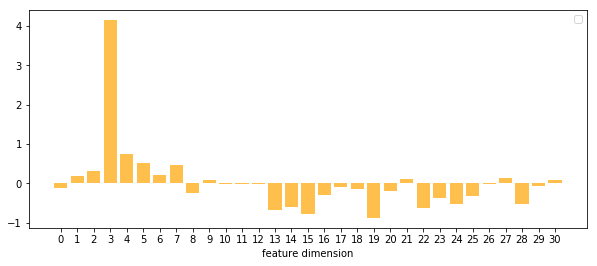

In [0]:
if use_gdrive:
  output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
else:
  output_path = f"./predictions/{folder}/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)

# for final model
if model.iterations != 0:
  W_c, W_e = W_s[0], W_s[1:]
  plt.figure(figsize=(10, 4)) # widht, height in inches
  #plt.bar(np.arange(1, F+1), W_c, label="W_c", color="blue", width=0.8, alpha=0.7)
  plt.bar(np.arange(0, F+1), W_s, color="orange", width=0.8, alpha=0.7)
  #plt.xlim([-2, +2]) # ?
  plt.legend()
  plt.xticks((np.arange(0, F+1, 1)))
  plt.xlabel("feature dimension")
  #plt.scatter(np.arange(1, F+1), W_e, label="W_e", color="orange", alpha=0.7)
  plt.savefig(output_path+"weights.png")
  plt.show()

In [0]:
## for final model
#
#
#W_c, W_e = W_s[0], W_s[1:]
#plt.figure(figsize=(10, 4)) # widht, height in inches
##plt.bar(np.arange(1, F+1), W_c, label="W_c", color="blue", width=0.8, alpha=0.7)
#for w in list(W_s[0]):
#  plt.bar(np.arange(1, F+2), w, color="orange" , width=0.8, alpha=0.7)
##plt.xlim([-2, +2]) # ?
#plt.legend()
#plt.xticks(np.arange(1, F+1, 1))
##plt.scatter(np.arange(1, F+1), W_e, label="W_e", color="orange", alpha=0.7)
#plt.show()
#

In [0]:
## throughout epochs
#print(len(model.W_list))
#for i, W_pair in enumerate(model.W_list):
#  print(f"epoch: {(i+1)*iter_plot_ELBO}")
#  W_c, W_e = W_s[0], W_s[1:]
#  #plt.scatter(np.arange(1, F+1), W_c.cpu().detach().numpy(), label="W_c", alpha=0.7) # F <- (1, F)
#  plt.plot(np.arange(1, F+1), np.ones(F)*W_c.cpu().detach().numpy(), label="W_c", alpha=0.7) # F <- (1, F)
#  #plt.plot(np.arange(1, F+1), np.ones(F)*W_e.cpu().detach().numpy(), label="W_e", color="orange", alpha=0.7)
#  plt.scatter(np.arange(1, F+1), W_e.squeeze(1).cpu().detach().numpy(), label="W_e", color="orange", alpha=0.7)
#  plt.legend()
#  #plt.ylim([-2, +2]) # ?
#  #plt.yticks(np.a range(-2, 2.1, 0.1))
#  plt.grid()
#  plt.show()
#  #plt.savefig(output_path+f"weights_epoch_{epoch}.png")

In [0]:
#if len(self.ELBO_graphs) <= 10:
#  for i, graph in enumerate(self.ELBO_graphs):
#    plt.plot(np.arange(1, self.iterations+1), graph, label=f"epoch {i+1}")
#    plt.legend()
#  plt.show()
#else:
#  stepsize = int(len(ELBO_graphs)/10)
#  for i, graph in enumerate(self.ELBO_graphs[::stepsize]):
#    plt.plot(np.arange(1, self.iterations+1), graph, label=f"epoch {i+1}")
#    plt.legend()
#  plt.show() 

In [0]:
if use_gdrive:
  output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
else:
  output_path = f"./predictions/{folder}/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
with open(output_path+"learning_metrics_train_valid.txt", "w") as f: 
  # accuracy = valid_accuracy , sensitivity = valid_sensitivity, specificity = valid_specificity (the last two are ONLY computed for valid/test set anyway
  if model.iterations != 0:
    for epoch, mean_train_loss, mean_valid_loss, train_accuracy, accuracy, sensitivity, specificity in zip(np.arange(1, epochs+1), mean_train_losses, mean_valid_losses, train_acc_list, acc_list, sens_list, spec_list):
      f.write("epoch : {}, time for epoch: {}, train loss : {:.4f}, valid loss : {:.2f}, train accuracy: {:.2f}, valid accuracy: {:.2f}, valid sensitivity: {:.2f}, valid specificity: {:.2f}\n"\
              .format(epoch, epoch_timer.get_time_hhmmss(), mean_train_loss, mean_valid_loss, train_accuracy, accuracy, sensitivity, specificity))
  else:
    for epoch, mean_train_loss, mean_valid_loss, train_accuracy, accuracy, sensitivity, specificity in zip(np.arange(1, epochs+1), mean_mlp_train_losses, mean_mlp_valid_losses, train_acc_list, acc_list, sens_list, spec_list):
      f.write("epoch : {}, time for epoch: {}, train loss : {:.4f}, valid loss : {:.2f}, train accuracy: {:.2f}, valid accuracy: {:.2f}, valid sensitivity: {:.2f}, valid specificity: {:.2f}\n"\
              .format(epoch, epoch_timer.get_time_hhmmss(), mean_train_loss, mean_valid_loss, train_accuracy, accuracy, sensitivity, specificity))

In [0]:
len(model.ELBO_graphs)
model.iterations

6

ELBO saved: 10


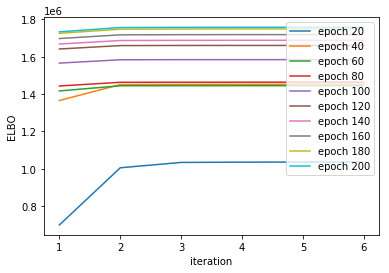

EX_psi_u saved: 10


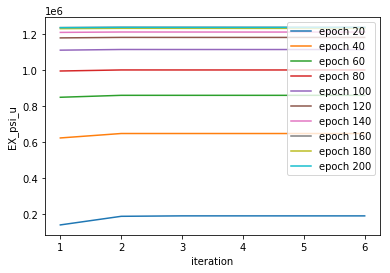

EX_psi_p saved: 10


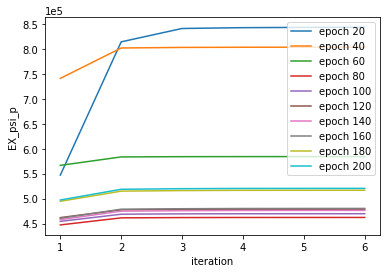

H saved: 10


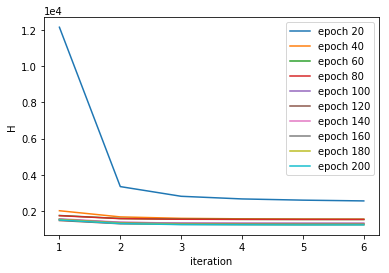

In [0]:
import matplotlib.ticker as ticker

def make_graph(graph_list, title_str):  
  # only elbo plots for validation are saved
  print(f"{title_str} saved: {len(graph_list)}")
  if not os.path.exists(output_path):
    # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
    os.makedirs(output_path)
  plt.xlabel("iteration")
  plt.ylabel(title_str)
  #plt.ylabel("pseudo ELBO")
  for i, graph in enumerate(graph_list):
    #fig, ax = plt.subplots()
    #print(type(graph)) # <class: list>
    plt.plot(np.arange(1, model.iterations+1), graph, label=f"epoch {(i+1)*iter_plot_ELBO}")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # scilimits= use sci not for every number outside this range
    tickpos = np.arange(1, model.iterations+1)
    plt.xticks(tickpos, tickpos) # will label "tickpos" with "tickpos" (meaning just the integers because tickpos contains no non-ints)
    #plt.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.legend()
    plt.legend(loc='upper right')
  plt.savefig(output_path+f"{title_str}.png")
  if use_nb:
    plt.show()

if len(model.ELBO_graphs) != 0:
  make_graph(model.ELBO_graphs, "ELBO")
  make_graph(model.EX_psi_u_graphs, "EX_psi_u")
  make_graph(model.EX_psi_p_graphs, "EX_psi_p")
  make_graph(model.H_graphs, "H")

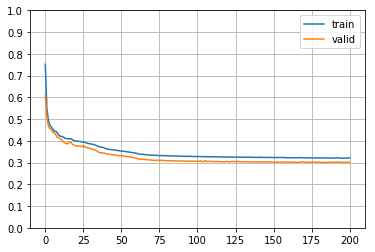

In [0]:
if model.iterations != 0:
  plt.plot(mean_train_losses, label="train")
  plt.plot(mean_valid_losses, label="valid")
  #plt.plot(mean_valid_losses, label="test")
  plt.legend()
  plt.ylim([0, 1])
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.grid()
  plt.savefig(output_path+"loss_plot.png")
  if use_nb:
    plt.show()
else:
  plt.plot(mean_mlp_train_losses, label="train")
  plt.plot(mean_mlp_valid_losses, label="valid")
  plt.legend()
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.grid()
  plt.ylim([0, 1])
  plt.savefig(output_path+"loss_plot.png")
  if use_nb:
    plt.show()

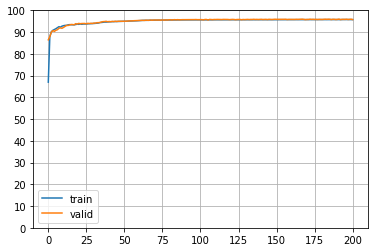

In [0]:
plt.plot(train_acc_list, label="train")
plt.plot(acc_list, label="valid")
#plt.plot(mean_valid_losses, label="test")
plt.legend()
plt.ylim([0, 100])
plt.yticks(np.arange(0, 101, 10))
plt.grid()
plt.savefig(output_path+"acc_plot.png")
plt.show()

In [0]:
print(len(outputs_train), len(outputs_val))
print(len(mlp_outputs_train), len(mlp_outputs_val))
# for MFN:
# epochs epochs
# epochs 0

# for MLP:
# 0 0?
# epochs epochs?

201 201
201 0


number of epochs: 201
201 training outputs were saved.
epoch 1:


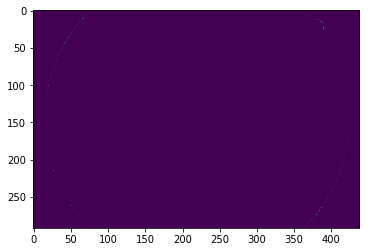

epoch 21:


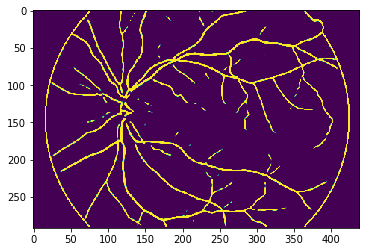

epoch 41:


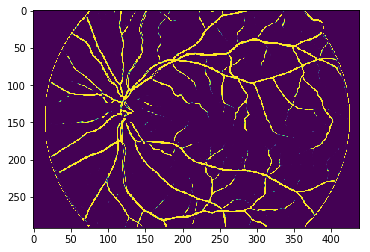

epoch 61:


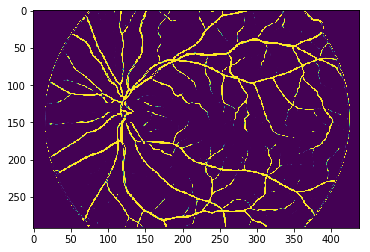

epoch 81:


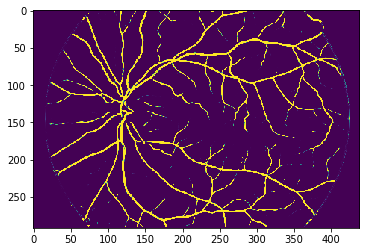

epoch 101:


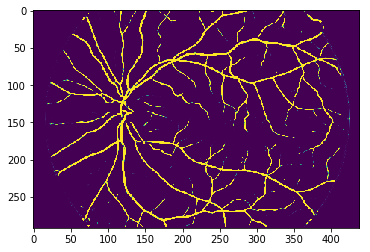

epoch 121:


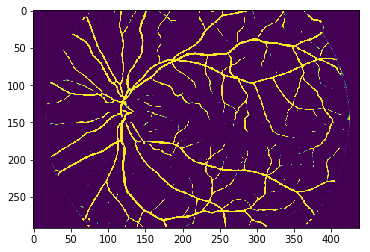

epoch 141:


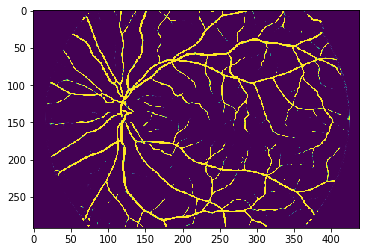

epoch 161:


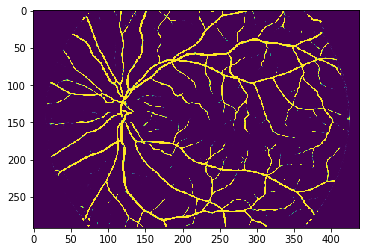

epoch 181:


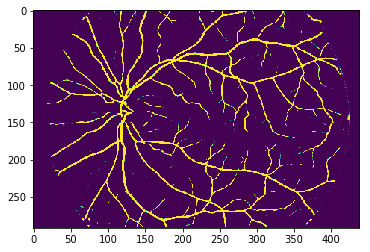

epoch 201:


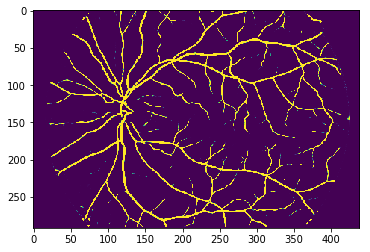

ground truth of first train image for reference:


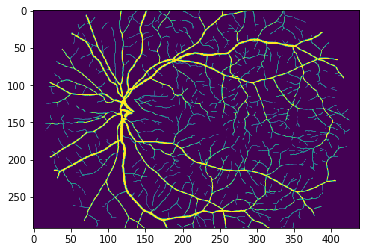

In [0]:
if model.iterations == 0:
  outputs_train, outputs_val = mlp_outputs_train, mlp_outputs_val  # WATCH OUT
if not os.path.exists(output_path+"training/"):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path+"training/")
print(f"number of epochs: {epochs}")
# loop in steaps of step_size, syntax: [start:stop:step_size]
if epochs <= 10:
  for i, outputs in enumerate(outputs_train):
    epoch = i+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+"training/"+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    if use_nb:
      plt.show()
else:
  print(f"{len(outputs_train)} training outputs were saved.")
  for i, outputs in enumerate(outputs_train[::step_size]):
    epoch = i*step_size+1
    #epoch = i+1
    #epoch = i*(epochs-1)/num_saves+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+"training/"+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    if use_nb:
      plt.show()
print("ground truth of first train image for reference:")
plt.imshow(y_train.cpu()[0,:,:])
plt.savefig(output_path+"training/"+"ground_truth.png")
if use_nb:
  plt.show()

number of epochs: 201
201 validation outputs were saved.
epoch 1:


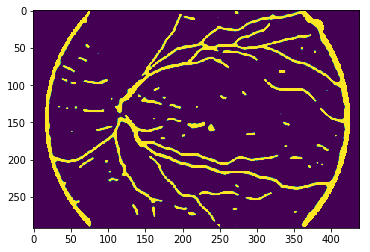

epoch 21:


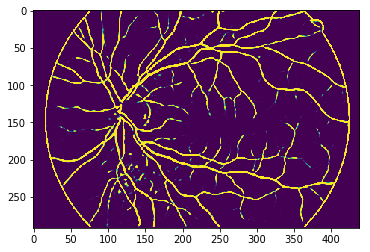

epoch 41:


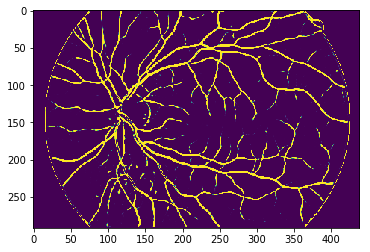

epoch 61:


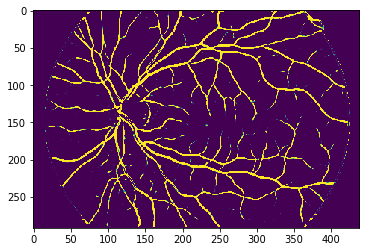

epoch 81:


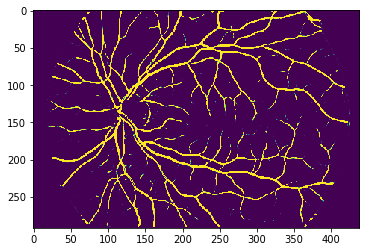

epoch 101:


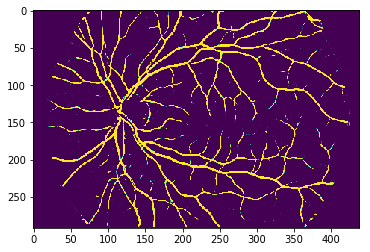

epoch 121:


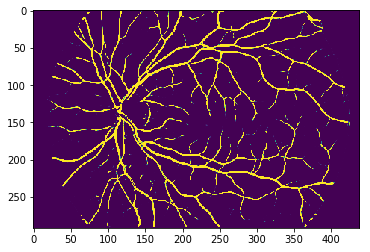

epoch 141:


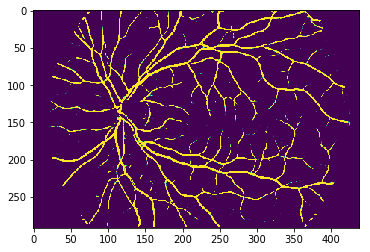

epoch 161:


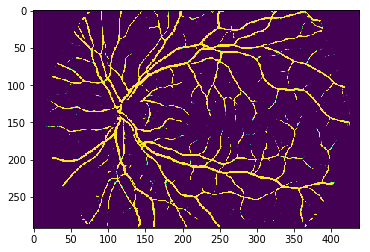

epoch 181:


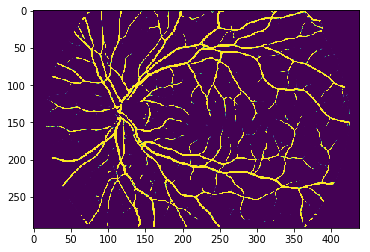

epoch 201:


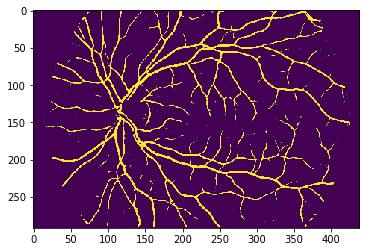

ground truth of first validation image for reference:


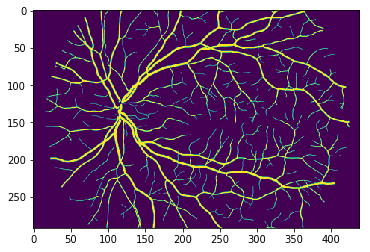

In [0]:
#output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
if not os.path.exists(output_path+"validation/"):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path+"validation/")
print(f"number of epochs: {epochs}")
# loop in steaps of step_size, syntax: [start:stop:step_size]
if epochs <= 10:
  for i, outputs in enumerate(outputs_val):
    epoch = i+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+"validation/"+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    if use_nb:
      plt.show()
else:
  print(f"{len(outputs_val)} validation outputs were saved.")
  for i, outputs in enumerate(outputs_val[::step_size]):
    epoch = i*step_size+1
    #epoch = i*(epochs-1)/num_saves+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+"validation/"+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    if use_nb:
      plt.show()
print("ground truth of first validation image for reference:")
plt.imshow(y_val.cpu()[0,:,:])
plt.savefig(output_path+"validation/"+"ground_truth.png")
if use_nb:
  plt.show()

In [0]:
## sanity check
#
#print(outputs.data.shape)
##print(outputs.data)
#prediction_img_ten = outputs.data.view(h, w).cpu().detach()
#print(prediction_img_ten.shape)
##pred_img = ToPILImage(predicted) # might have to copy channel 3 times
#plt.imshow(prediction_img_ten, cmap='viridis')  # viridis: 0 = mauve, 1 = yellow
#if use_nb:
#  plt.show()
#print(f"prediction_img_ten is cpu: {not prediction_img_ten.is_cuda}")
##print(prediction_img_ten[0,0])
##prediction_img_ten[:, 0] == 0
## torch.where(cond, a, b) returns element of a if cond, element of b else
## RuntimeError: Expected tensor to have cpu DeviceType, but got tensor with cuda DeviceType (while checking arguments for CPU_tensor_apply)

In [0]:
#model = torch.load(output_path+"models/model_195.pt") # load the epoch's model you want
## or load the state dictionary instead (recommended):
### hyperparameters ###########################################
# debug = False
# timers = False

# # path to save the model under
# epochs = 2001 # 201 # 2001
# step_size = 200  # save and plot every nth output image for train, val and test sets
# # following 2 parameters only matter for MFN, i.e. model.iterations > 0
# iter_plot_ELBO = 200 # 200 # n := iter_plot_ELBO, plot the ELBO plot over mfn <iterations> every n-th epoch, same for saving model.W_2D
# case = 1
# assert(case == 1 or case == 2 or case == 3)

# lr = 2e-2
# # reload the model so it is reinitialized
# # google colab has 12.7 GB RAM, which means h*w can't be bigger than ...?
# model = MFN(h=h, w=w, iterations=6)

# print(f"epochs: {epochs}")
# print(f"iter_plot_ELBO: {iter_plot_ELBO}")  # plot ELBO in every nth iteration (plot is saved in model under self.ELBO_graphs)
# print(f"step_size: {step_size}")
# print(f"case: {case}")
# print(f"learning rate: {lr}")#{optimizer.lr}")
# print(f"MF iterations: {model.iterations}")
# print(f"h, w, F: {model.h}, {model.w}, {F}")
# print(f"N: {model.N}")
# # borderless N
# print(f"bN: {model.bN}")
# E = adj_mat._nnz()
# print(f"E: {E}")
# print("E = 8*bN, becasue each non-border pixel has 8 neighbours")
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model = MFN(h=h, w=w, iterations=6)
# model.load_state_dict(output_path+"model_state_dict_195.pt")


# test code, delete this when done
#model = torch.load(f"/content/gdrive/My Drive/Master_Thesis/predictions/MFN_F_30_lr_2E-2_case_1_iterations_6_epochs_201img2_neigh8/models/model.pt")
#output_path = "/content/gdrive/My Drive/Master_Thesis/predictions/MFN_F_30_lr_2E-2_case_1_iterations_6_epochs_201img2_neigh8_reload_model/"

In [0]:
# use trained model on test set
# rerunning this cell will use the pretrained model of the cell above, but the losses and predictions are all reset to scratch

# ELBO_graphs is filled with valid ELBOs, now they are replaced with test ELBOS -> not interesting, like loss plot, ELBO is kind of a  debugging tool that you want to do on the validation set
#model.ELBO_graphs = []
#model.EX_psi_u_graphs = []
#model.EX_psi_p_graphs = []
#model.H_graphs = []

import torch.nn.functional as Fun  # usually imported as F but that variable is already the number of features

# put this into every cell that makes random choices
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  print("GPU is available.")
  torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = False

# for debugging purposes (Hint of error message where "variables needed for gradient computation has been modified by an inplace operation")
torch.autograd.set_detect_anomaly(False) # turn this off aybe this will make the code run faster
#torch.autograd.set_detect_anomaly(True) # will throw RuntimeError: Function 'DivBackward0' returned nan testues in its 0th output. after about 333 epochs


# save the mean losses of all forward-backward passes of one epoch, such as to plot them later
test_acc_list = []
sens_list = []
spec_list = []
outputs_test = []
mlp_outputs_test = []
#model.zero_grad()  #not needed, since reinitializing the model in the line above already zeros the grads

#X_train = 2*(X_train - X_train.min(2))
timer = Timer()
# one epoch is as many forward + backward passes until all training data was passed once
#for epoch in tqdm(range(epochs)):
  
  
# save losses after every batch of dataset that is read, i.e. after each forward-backward pass
test_losses = []
mlp_test_losses = []
  
# Tell the mlp that we're evaluating now, so requires_grad = False for all tensors
# model.eval() will notify all our layers that you are in eval mode,
# that way, batchnorm or dropout layers will work in eval mode instead of 
# training mode.
model.eval()  # sets nn.Module's self.training attribute to False
# to manually calculate accuracy, we need # of correct and total #
correct = 0
total = 0
TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0
# no backpropagation needed in this part, this speeds up computation
with torch.no_grad():
  # runs forward pass on the data point from test set
  for i, (image, labels, mask, sim) in list(enumerate(zip(X_test, y_test, mask_test, sims_test))):#[:2]:
    # try on 4 vtestimages so that there is a little more variation, 
    # especially relevant since images in HRF can be flipped along middle 
    # vertical axis
    mask = mask.type(torch.ByteTensor)  # cast to boolean tensor in order to make indexing possible [addendum: actually casts from default (float) to dtype=torch.uint8)]
    # Every time a variable is back-propogated through, the gradient will be accumulated instead of being replaced. (This makes it easier for rnn, because each module will be back propogated through several times.)
    # To prevent this, we manually zero the gradients after each batch
    optimizer.zero_grad()
    # runs forward pass on the data point from training set
    if model.iterations != 0:
      mlp_outputs, outputs = model(image, sim)
    else:
      mlp_outputs = model(image, sim)
    #print(f"outputs for image number {i}")
    #plt.imshow(outputs.detach().cpu().numpy()[:,:,0])  # in the MFI iterations I used clone().cpu().detach()[:,:,0] instead, which seems to give identical result
    #plt.show()
    
    #if model.iterations == 0:
    #  outputs = mlp_outputs ##### WATCH OUT!
    
    # only one image is saved for test, since there is no epoch loop in here
    if model.iterations != 0:
      outputs_test.append(outputs)
    else:
      mlp_outputs_test.append(mlp_outputs)
        
    # mask is a (h, w)-shaped binary tensor
    mask = mask.type(torch.ByteTensor)  # cast to boolean tensor in order to make indexing possible
    
    #if model.iterations != 0:
    #  mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])  # loss function can compare probs to binary values
    #  mlp_test_losses.append(mlp_loss.item())
    #
    #loss = loss_fn(outputs[mask], labels[mask])  # loss function can compare probs to binary values
    #test_losses.append(loss.item())
    
    mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])
    if model.iterations != 0:
      loss = loss_fn(outputs[mask], labels[mask])
      # after each image read-in, the loss is saved
      test_losses.append(loss.item())
      mlp_test_losses.append(mlp_loss.item())      
    else:
      mlp_test_losses.append(mlp_loss.item())
    
       
    if model.iterations != 0:
      #for accuracy we want the total count -> threshold predictions
      bin_outputs = threshold(outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
    else:
      bin_outputs = threshold(mlp_outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
    
    bin_labels = threshold(labels, 0.5)  # because labels is resized, values are interpolated and no longer binary
    correct += (bin_outputs[mask] == bin_labels[mask]).sum().item()
    total += mask.sum().item() # counts the number of 'True' inside mask, 'True' = 1 = white = field of view
    
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 1))
    
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 0))
     
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 0))
     
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 1))
    
    TP_total += TP
    TN_total += TN
    FP_total += FP
    FN_total += FN

mean_accuracy = 100*correct/total # *100 to get it in percent
# cast to int because otherwise floating point inprecisions result in rounded-down numbers
#mean_accuracy2 = 100*int(TP_total+TN_total)/int(TP_total+TN_total+FP_total+FN_total)  # same result as line above

mean_sensitivity = 100*int(TP_total)/int(TP_total+FN_total)  # cast to int because otherwise floating point inprecisions result in round numbers
mean_specificity = 100*int(TN_total)/int(TN_total+FP_total)  # cast to int because otherwise floating point inprecisions result in round numbers

test_acc_list.append(mean_accuracy)
sens_list.append(mean_sensitivity)
spec_list.append(mean_specificity)

# mean_acc/sens/spec are equal for mlp and mfn since we saved both as "outputs" a few lines above. This is legit because we are only concerned about the end acc/sens/spec, we don't want to compare them between mlp/mfn as we already do that for loss
if model.iterations != 0:
  mean_test_loss = np.mean(test_losses)
  print("train loss : {:.4f}, test loss: {:.4f}, test accuracy: {:.2f}, test sensitivity: {:.2f}, test specificity: {:.2f}"\
       .format(mean_train_losses[-1], mean_test_loss, mean_accuracy, mean_sensitivity, mean_specificity))
else:# mlp doesn't fill the list train_losses
  mean_test_loss = np.mean(mlp_test_losses)
  print("train loss : {:.4f}, test loss : {:.4f}, test accuracy: {:.2f}, test sensitivity: {:.2f}, test specificity: {:.2f}"\
       .format(mean_train_losses[-1], mean_test_loss, mean_accuracy, mean_sensitivity, mean_specificity)) 

GPU is available.
train loss : 0.3214, test loss: 0.3180, test accuracy: 95.42, test sensitivity: 80.56, test specificity: 96.81


In [0]:
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
  
print("Mean test loss: {:.4f}".format(mean_test_loss))
print("Mean accuracy: {:.4f}".format(mean_accuracy))
print("Mean sensitivity: {:.4f}".format(sensitivity))
print("Mean specificity: {:.4f}".format(specificity))

with open(output_path+"learning_metrics_test.txt", "w") as f:
    f.write("Mean test loss: {:.4f}\nMean accuracy: {:.2f}\nMean sensitivity: {:.2f}\nMean specificity: {:.2f}"\
            .format(mean_test_loss, mean_accuracy, sensitivity, specificity))

Mean test loss: 0.3180
Mean accuracy: 95.4230
Mean sensitivity: 81.9083
Mean specificity: 97.0671


number of epochs: 201
9 test outputs were saved.
prediction image 0:


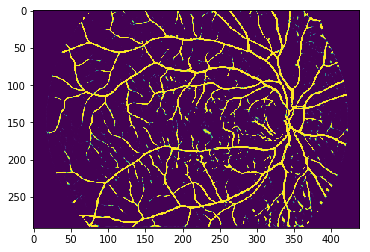

ground truth image 0:


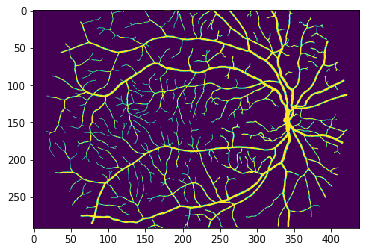

prediction image 1:


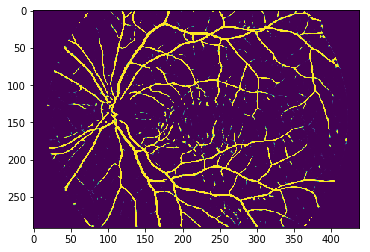

ground truth image 1:


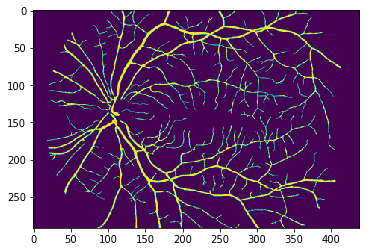

prediction image 2:


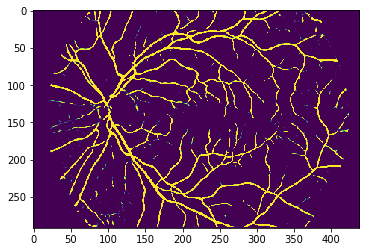

ground truth image 2:


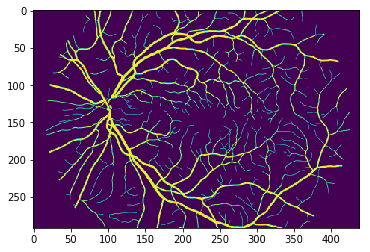

prediction image 3:


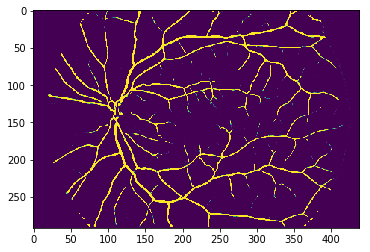

ground truth image 3:


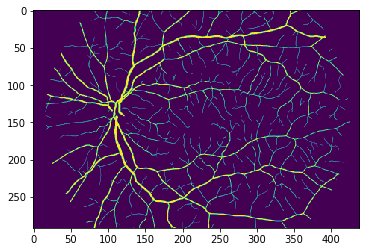

prediction image 4:


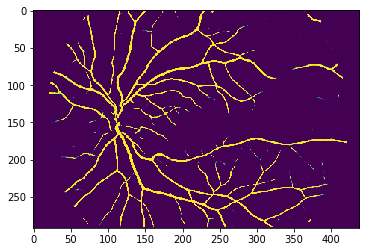

ground truth image 4:


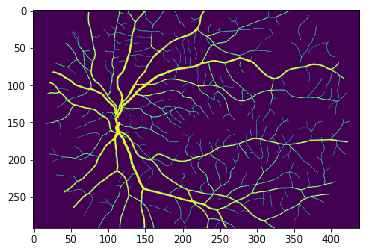

prediction image 5:


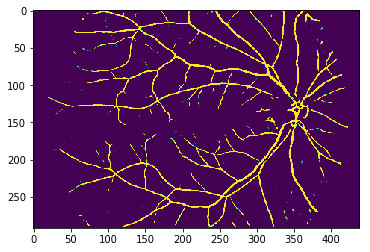

ground truth image 5:


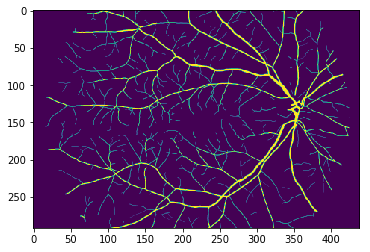

prediction image 6:


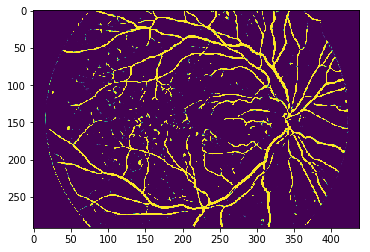

ground truth image 6:


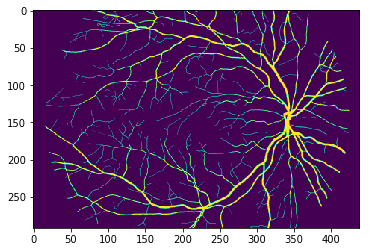

prediction image 7:


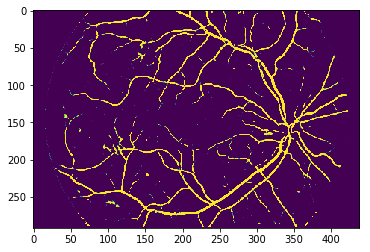

ground truth image 7:


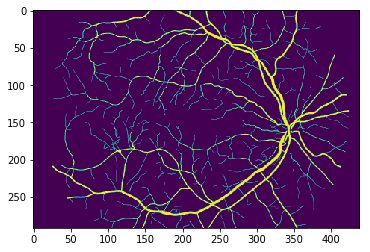

prediction image 8:


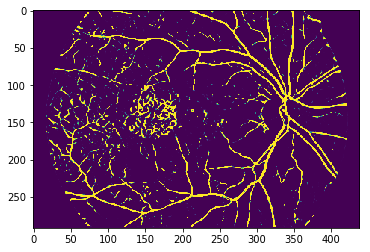

ground truth image 8:


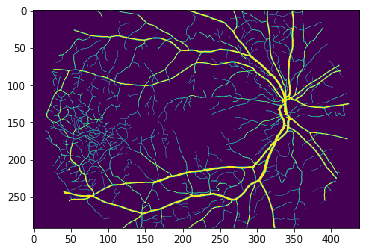

In [0]:
if model.iterations == 0:
  outputs_test = mlp_outputs_test # WATCH OUT!
#output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
if not os.path.exists(output_path+"test/"):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path+"test/")
print(f"number of epochs: {epochs}")
# loop in steaps of step_size, syntax: [start:stop:step_size]

print(f"{len(outputs_test)} test outputs were saved.")
for i, outputs in enumerate(outputs_test):
  print(f"prediction image {i}:")
  plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
  plt.savefig(output_path+"test/"+f"img_{str(i).zfill(2)}_pred.png")  # zfill(n) makes number n digits long with leading 0s
  if use_nb:
    plt.show()
  else:
    plt.clf()

  print(f"ground truth image {i}:")
  plt.imshow(y_test.cpu()[i,:,:])
  plt.savefig(output_path+"test/"+f"img{str(i).zfill(2)}_ground_truth.png")
  if use_nb:
    plt.show()
  else:
    plt.clf()

9
red = false negative, blue = false positive
test image 1
sensitivity (red makes this small): 75.52
specificity (blue makes this small): 96.43


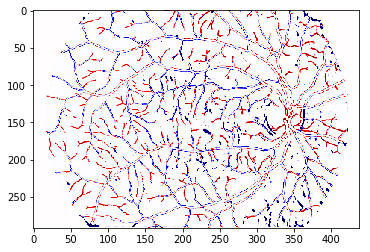

test image 2
sensitivity (red makes this small): 81.08
specificity (blue makes this small): 96.89


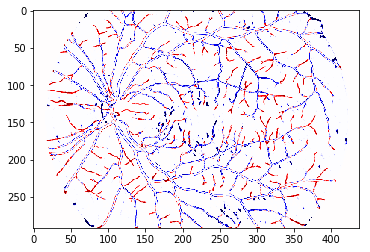

test image 3
sensitivity (red makes this small): 80.06
specificity (blue makes this small): 97.88


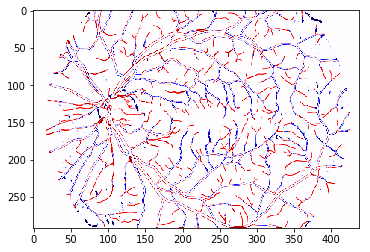

test image 4
sensitivity (red makes this small): 83.83
specificity (blue makes this small): 97.49


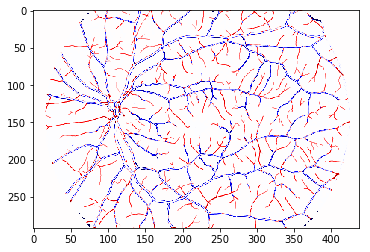

test image 5
sensitivity (red makes this small): 83.09
specificity (blue makes this small): 97.82


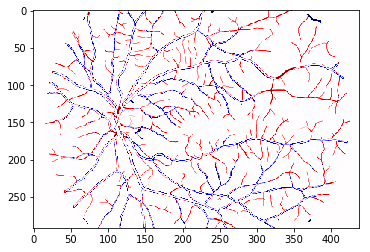

test image 6
sensitivity (red makes this small): 85.43
specificity (blue makes this small): 97.47


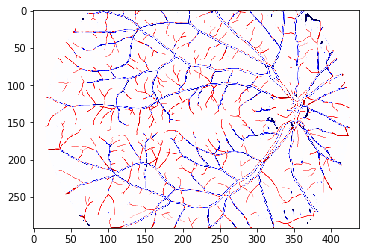

test image 7
sensitivity (red makes this small): 83.88
specificity (blue makes this small): 95.49


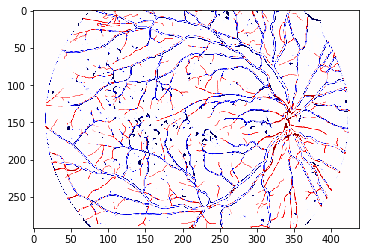

test image 8
sensitivity (red makes this small): 82.63
specificity (blue makes this small): 97.02


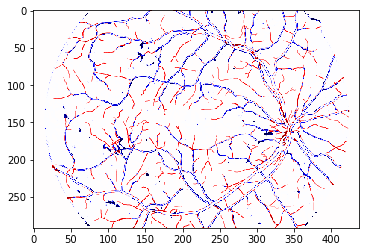

test image 9
sensitivity (red makes this small): 73.75
specificity (blue makes this small): 94.77


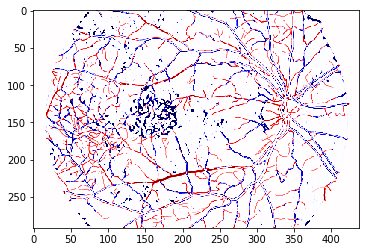

red = false negative, blue = false positive


In [0]:
print(len(outputs_test))
print(f"red = false negative, blue = false positive")
for i, (pred, ground_truth, mask) in enumerate(zip(outputs_test, y_test, mask_test)):
  print(f"test image {i+1}")
  bin_outputs = threshold(pred, 0.5).squeeze(2)
  bin_labels = threshold(ground_truth, 0.5)  
  mask = mask.type(torch.ByteTensor)
  
  TP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 1)) 
  TN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 0))
  FN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 1))
  FP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 0))     

  sensitivity = 100*int(TP)/int(TP+FN)  # cast to int because otherwise floating point inprecisions result in round numbers
  specificity = 100*int(TN)/int(TN+FP)
  
  #total = mask.sum().item()
  #print(f"FN rate (red): {FP.item()/total}")
  #print(f"FP rate (blue): {FP.item()/total}")
  print("sensitivity (red makes this small): {:.2f}".format(sensitivity))
  print("specificity (blue makes this small): {:.2f}".format(specificity))
  pred_numpy = pred.detach().cpu().numpy()[:,:,0]  # len(outputs_test) = 1 so we get the only preiciton we make on image0
  ground_truth_numpy = ground_truth.cpu().numpy()

  plt.imshow(ground_truth_numpy - pred_numpy, cmap="seismic")
  plt.show()
  #plt.savefig(output_path+"test/"+"img{str(i).zfill(2)}_difference_test.png")
print(f"red = false negative, blue = false positive")

In [0]:
print((ground_truth_numpy - pred_numpy).min())
print((ground_truth_numpy - pred_numpy).max())

-1.0
1.0


In [0]:
##print(mask_test.cpu()[0].shape)
#mask = mask_test.cpu()[0].type(torch.ByteTensor).cpu().numpy()  # cast to boolean tensor in order to make indexing possible [addendum: actually casts from default (float) to dtype=torch.uint8)]
#print(mask.shape)
#plt.imshow(mask, cmap="seismic")
#print((ground_truth - prediction).shape)
#print((ground_truth - prediction)[mask].shape)
##plt.imshow((ground_truth - prediction)[mask][:,:,437], cmap="seismic")
#plt.savefig(output_path+"difference_test_image2.png")
##print(f"red = false negative, blue = false positive")

9
red = false negative, blue = false positive
test image 1
sensitivity (red makes this small): 75.52
specificity (blue makes this small): 96.43


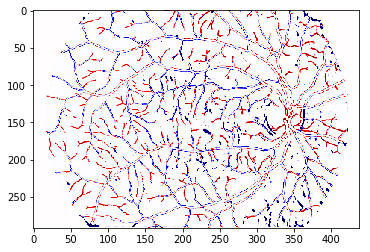

test image 2
sensitivity (red makes this small): 81.08
specificity (blue makes this small): 96.89


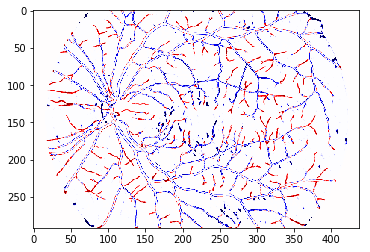

test image 3
sensitivity (red makes this small): 80.06
specificity (blue makes this small): 97.88


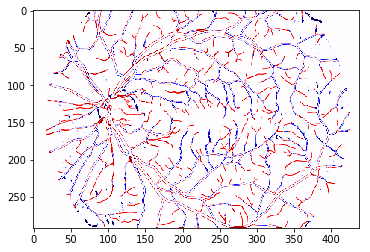

test image 4
sensitivity (red makes this small): 83.83
specificity (blue makes this small): 97.49


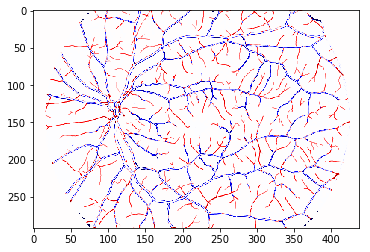

test image 5
sensitivity (red makes this small): 83.09
specificity (blue makes this small): 97.82


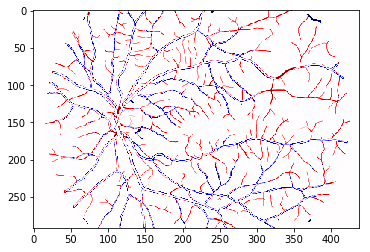

test image 6
sensitivity (red makes this small): 85.43
specificity (blue makes this small): 97.47


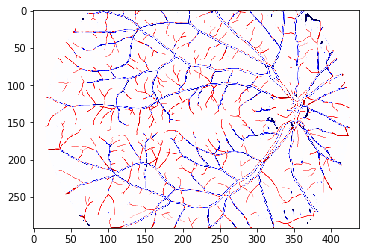

test image 7
sensitivity (red makes this small): 83.88
specificity (blue makes this small): 95.49


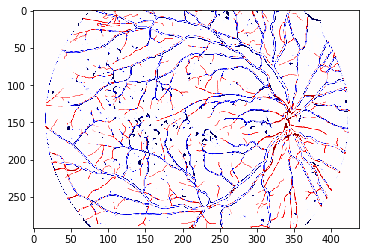

test image 8
sensitivity (red makes this small): 82.63
specificity (blue makes this small): 97.02


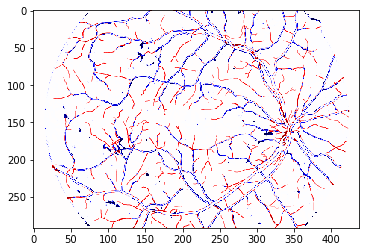

test image 9
sensitivity (red makes this small): 73.75
specificity (blue makes this small): 94.77


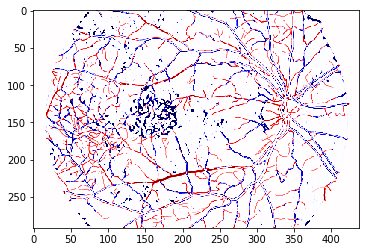

red = false negative, blue = false positive


In [0]:
print(len(outputs_test))
print(f"red = false negative, blue = false positive")
for i, (pred, ground_truth, mask) in enumerate(zip(outputs_test, y_test, mask_test)):

  bin_outputs = threshold(pred, 0.5).squeeze(2)
  bin_labels = threshold(ground_truth, 0.5)  
  mask = mask.type(torch.ByteTensor)
  
  TP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 1)) 
  TN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 0))
  FN = torch.sum((bin_outputs[mask] == 0) & (bin_labels[mask] == 1))
  FP = torch.sum((bin_outputs[mask] == 1) & (bin_labels[mask] == 0))     

  sensitivity = 100*int(TP)/int(TP+FN)  # cast to int because otherwise floating point inprecisions result in round numbers
  specificity = 100*int(TN)/int(TN+FP)
  
  #total = mask.sum().item()
  #print(f"FN rate (red): {FP.item()/total}")
  #print(f"FP rate (blue): {FP.item()/total}")
  print(f"test image {i+1}")
  print("sensitivity (red makes this small): {:.2f}".format(sensitivity))
  print("specificity (blue makes this small): {:.2f}".format(specificity))
  with open(output_path+"test/diff_metrics.txt", "a") as f:
    f.write(f"test image {i+1}\n")
    f.write("sensitivity (red makes this small): {:.2f}\n".format(sensitivity))
    f.write("specificity (blue makes this small): {:.2f}\n".format(specificity))
  pred_numpy = pred.detach().cpu().numpy()[:,:,0]  # len(outputs_test) = 1 so we get the only preiciton we make on image0
  ground_truth_numpy = ground_truth.cpu().numpy()

  plt.imshow(ground_truth_numpy - pred_numpy, cmap="seismic")
  plt.savefig(output_path+"test/"+f"diff_img{str(i+1).zfill(2)}.png")
  plt.show()
print(f"red = false negative, blue = false positive")